# 📊 Análise Comparativa Abrangente entre Datasets de Diabetes

## Original vs. Múltiplas Técnicas de Limpeza

Este notebook analisa as diferenças entre o dataset original de diabetes (`diabetes.csv`) e quatro datasets processados com diferentes técnicas de limpeza:

1. **diabetes_cleaned_MEDIANA.csv** - Imputação por mediana
2. **diabetes_cleaned_knn_constraints.csv** - Imputação por KNN com restrições
3. **diabetes_cleaned_REGRESSAO.csv** - Imputação por regressão
4. **diabetes_cleaned_REMOCAO_PURA.csv** - Remoção de observações com valores faltantes

O objetivo é entender:

1. As transformações aplicadas por cada técnica de processamento
2. O impacto dessas transformações nos dados
3. Potenciais implicações para modelos em termos de overfitting
4. Vantagens e desvantagens de cada abordagem de limpeza

In [2]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
colors = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

# Definir seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)

## 1. Carregamento de Todos os Datasets

In [3]:
# Carregar todos os datasets
df_original = pd.read_csv('diabetes.csv')
df_mediana = pd.read_csv('diabetes_cleaned_MEDIANA.csv')
df_knn_constraints = pd.read_csv('diabetes_cleaned_KNN_CONSTRAINTS.csv')
df_regressao = pd.read_csv('diabetes_cleaned_REGRESSAO.csv')
df_remocao_pura = pd.read_csv('diabetes_cleaned_REMOCAO_PURA.csv')

# Criar dicionário para facilitar iteração
datasets = {
    'Original': df_original,
    'Mediana': df_mediana,
    'KNN Constraints': df_knn_constraints,
    'Regressão': df_regressao,
    'Remoção Pura': df_remocao_pura
}

# Exibir informações básicas
print("\n" + "=" * 70)
print("📊 INFORMAÇÕES BÁSICAS DE TODOS OS DATASETS")
print("=" * 70)

for nome, df in datasets.items():
    print(f"\n📋 Dataset {nome}:")
    print(f"   • Dimensões: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print(f"   • Colunas: {list(df.columns)}")


📊 INFORMAÇÕES BÁSICAS DE TODOS OS DATASETS

📋 Dataset Original:
   • Dimensões: 768 linhas, 9 colunas
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

📋 Dataset Mediana:
   • Dimensões: 768 linhas, 8 colunas
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

📋 Dataset KNN Constraints:
   • Dimensões: 768 linhas, 8 colunas
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

📋 Dataset Regressão:
   • Dimensões: 768 linhas, 8 colunas
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

📋 Dataset Remoção Pura:
   • Dimensões: 752 linhas, 7 colunas
   • Colunas: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


## 2. Análise Estrutural das Diferenças

In [4]:
# Comparar colunas
print("\n" + "=" * 60)
print("📊 ANÁLISE ESTRUTURAL DAS DIFERENÇAS")
print("=" * 60)

print(f"\n📋 Colunas do Dataset Original: {list(df_original.columns)}")
print(f"📋 Colunas do Dataset Processado: {list(df_mediana.columns)}")

# Identificar diferenças estruturais
colunas_removidas = set(df_original.columns) - set(df_mediana.columns)
colunas_adicionadas = set(df_mediana.columns) - set(df_original.columns)

print(f"\n🔍 DIFERENÇAS ESTRUTURAIS:")
print(f"   • Colunas removidas: {colunas_removidas if colunas_removidas else 'Nenhuma'}")
print(f"   • Colunas adicionadas: {colunas_adicionadas if colunas_adicionadas else 'Nenhuma'}")
print(f"   • Número de linhas original vs processado: {df_original.shape[0]} vs {df_mediana.shape[0]}")

# Comparar estruturas de todos os datasets
print("\n" + "=" * 80)
print("📊 ANÁLISE ESTRUTURAL COMPARATIVA DE TODOS OS DATASETS")
print("=" * 80)

# Análise de dimensões
print("\n📊 RESUMO DAS DIMENSÕES:")
dim_summary = pd.DataFrame({
    'Linhas': [df.shape[0] for df in datasets.values()],
    'Colunas': [df.shape[1] for df in datasets.values()],
    'Total_Células': [df.shape[0] * df.shape[1] for df in datasets.values()]
}, index=datasets.keys())
print(dim_summary)

# Análise de colunas presentes/ausentes
print("\n📊 ANÁLISE DE COLUNAS:")
todas_colunas = set()
for df in datasets.values():
    todas_colunas.update(df.columns)

col_presence = pd.DataFrame(index=sorted(todas_colunas), columns=datasets.keys())
for nome, df in datasets.items():
    for col in todas_colunas:
        col_presence.loc[col, nome] = '✓' if col in df.columns else '✗'

print(col_presence)

# Calcular perda de dados por método
print("\n📊 PERDA DE DADOS POR MÉTODO:")
original_size = df_original.shape[0]
data_loss = pd.DataFrame({
    'Observações': [df.shape[0] for df in datasets.values()],
    'Perda_Absoluta': [original_size - df.shape[0] for df in datasets.values()],
    'Perda_Percentual': [(original_size - df.shape[0]) / original_size * 100 for df in datasets.values()]
}, index=datasets.keys())
print(data_loss.round(2))


📊 ANÁLISE ESTRUTURAL DAS DIFERENÇAS

📋 Colunas do Dataset Original: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
📋 Colunas do Dataset Processado: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

🔍 DIFERENÇAS ESTRUTURAIS:
   • Colunas removidas: {'Insulin'}
   • Colunas adicionadas: Nenhuma
   • Número de linhas original vs processado: 768 vs 768

📊 ANÁLISE ESTRUTURAL COMPARATIVA DE TODOS OS DATASETS

📊 RESUMO DAS DIMENSÕES:
                 Linhas  Colunas  Total_Células
Original            768        9           6912
Mediana             768        8           6144
KNN Constraints     768        8           6144
Regressão           768        8           6144
Remoção Pura        752        7           5264

📊 ANÁLISE DE COLUNAS:
                         Original Mediana KNN Constraints Regressão  \
Age                             ✓       ✓  

## 3. Estatísticas Descritivas e Comparação de Distribuições

In [5]:
# Comparação estatística entre todos os datasets
print("\n" + "=" * 80)
print("📊 COMPARAÇÃO ESTATÍSTICA ENTRE TODOS OS DATASETS")
print("=" * 80)

# Função para calcular estatísticas descritivas formatadas
def get_stats(df):
    stats = df.describe().T
    stats['missing'] = df.isna().sum()
    stats['zeros'] = (df == 0).sum()
    stats['zeros_percent'] = ((df == 0).sum() / len(df) * 100).round(2)
    return stats

# Calcular estatísticas para todos os datasets
for nome, df in datasets.items():
    print(f"\n📊 ESTATÍSTICAS DO DATASET {nome.upper()}:")
    stats = get_stats(df)
    display(stats)
    print("\n" + "-" * 60)


📊 COMPARAÇÃO ESTATÍSTICA ENTRE TODOS OS DATASETS

📊 ESTATÍSTICAS DO DATASET ORIGINAL:


count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  missing  zeros  \
Pregnancies                 3.0000    6.00000   17.00        0    111   
Glucose                   117.0000  140.25000  199.00        0      5   
BloodPressure              72.0000   80.00000  122.00        0     35   
SkinThickness              23.0000   32.00000   99.00        0    227   
Insulin                    30.5000  127.25000  846.00        0    374   
BMI                        32.0000   36.60000   67.10        0     11   
DiabetesPedigreeFunction    0.3725    0.62625    2.42        0      0   
Age                        29.0000   41.00000   81.00        0      0   
Outcome                     0.0000    1.00000    1.00        0    500   

                          zeros_percent  
Pregnancies                       14.45  
Glucose                            0.65  
BloodPressure                      4.56  
SkinThickness                     29.56  
Insulin                           48.70  
BMI                                1.43  
DiabetesPedigreeFunction           0.00  
Age                                0.00  
Outcome                           65.10


------------------------------------------------------------

📊 ESTATÍSTICAS DO DATASET MEDIANA:


count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  121.677083  30.464161  44.000  99.75000   
BloodPressure             768.0   72.389323  12.106039  24.000  64.00000   
SkinThickness             768.0   29.089844   8.890820   7.000  25.00000   
BMI                       768.0   32.434635   6.880498  18.200  27.50000   
DiabetesPedigreeFunction  768.0    0.471876   0.331329   0.078   0.24375   
Age                       768.0   33.240885  11.760232  21.000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000   0.00000   

                               50%        75%     max  missing  zeros  \
Pregnancies                 3.0000    6.00000   17.00        0    111   
Glucose                   117.0000  140.25000  199.00        0      0   
BloodPressure              72.0000   80.00000  122.00        0      0   
SkinThickness              28.0000   32.00000   99.00        0      0   
BMI                        32.0500   36.60000   67.10        0      0   
DiabetesPedigreeFunction    0.3725    0.62625    2.42        0      0   
Age                        29.0000   41.00000   81.00        0      0   
Outcome                     0.0000    1.00000    1.00        0    500   

                          zeros_percent  
Pregnancies                       14.45  
Glucose                            0.00  
BloodPressure                      0.00  
SkinThickness                      0.00  
BMI                                0.00  
DiabetesPedigreeFunction           0.00  
Age                                0.00  
Outcome                           65.10


------------------------------------------------------------

📊 ESTATÍSTICAS DO DATASET KNN CONSTRAINTS:


count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  121.748698  30.463612  44.000  99.75000   
BloodPressure             768.0   72.341927  12.191613  24.000  64.00000   
SkinThickness             768.0   28.884375   9.486765   7.000  22.00000   
BMI                       768.0   32.457682   6.883050  18.200  27.50000   
DiabetesPedigreeFunction  768.0    0.471876   0.331329   0.078   0.24375   
Age                       768.0   33.240885  11.760232  21.000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000   0.00000   

                               50%        75%     max  missing  zeros  \
Pregnancies                 3.0000    6.00000   17.00        0    111   
Glucose                   117.0000  141.00000  199.00        0      0   
BloodPressure              72.0000   80.00000  122.00        0      0   
SkinThickness              28.8000   35.00000   99.00        0      0   
BMI                        32.3000   36.60000   67.10        0      0   
DiabetesPedigreeFunction    0.3725    0.62625    2.42        0      0   
Age                        29.0000   41.00000   81.00        0      0   
Outcome                     0.0000    1.00000    1.00        0    500   

                          zeros_percent  
Pregnancies                       14.45  
Glucose                            0.00  
BloodPressure                      0.00  
SkinThickness                      0.00  
BMI                                0.00  
DiabetesPedigreeFunction           0.00  
Age                                0.00  
Outcome                           65.10


------------------------------------------------------------

📊 ESTATÍSTICAS DO DATASET REGRESSÃO:


count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  121.682815  30.469813  44.000  99.75000   
BloodPressure             768.0   72.384034  12.117227  24.000  64.00000   
SkinThickness             768.0   29.325383   8.931387   7.000  25.00000   
BMI                       768.0   32.446279   6.878612  18.200  27.50000   
DiabetesPedigreeFunction  768.0    0.471876   0.331329   0.078   0.24375   
Age                       768.0   33.240885  11.760232  21.000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000   0.00000   

                               50%         75%     max  missing  zeros  \
Pregnancies                 3.0000    6.000000   17.00        0    111   
Glucose                   117.0000  141.000000  199.00        0      0   
BloodPressure              72.0000   80.000000  122.00        0      0   
SkinThickness              29.0000   33.382629   99.00        0      0   
BMI                        32.1500   36.600000   67.10        0      0   
DiabetesPedigreeFunction    0.3725    0.626250    2.42        0      0   
Age                        29.0000   41.000000   81.00        0      0   
Outcome                     0.0000    1.000000    1.00        0    500   

                          zeros_percent  
Pregnancies                       14.45  
Glucose                            0.00  
BloodPressure                      0.00  
SkinThickness                      0.00  
BMI                                0.00  
DiabetesPedigreeFunction           0.00  
Age                                0.00  
Outcome                           65.10


------------------------------------------------------------

📊 ESTATÍSTICAS DO DATASET REMOÇÃO PURA:


count        mean        std     min     25%  \
Pregnancies               752.0    3.851064   3.375189   0.000   1.000   
Glucose                   752.0  121.941489  30.601198  44.000  99.750   
BloodPressure             752.0   69.704787  18.322255   0.000  64.000   
BMI                       752.0   32.454654   6.928926  18.200  27.500   
DiabetesPedigreeFunction  752.0    0.473051   0.330108   0.078   0.244   
Age                       752.0   33.312500  11.709395  21.000  24.000   
Outcome                   752.0    0.351064   0.477621   0.000   0.000   

                              50%       75%     max  missing  zeros  \
Pregnancies                 3.000    6.0000   17.00        0    108   
Glucose                   117.000  141.0000  199.00        0      0   
BloodPressure              72.000   80.0000  122.00        0     28   
BMI                        32.300   36.6000   67.10        0      0   
DiabetesPedigreeFunction    0.377    0.6275    2.42        0      0   
Age                        29.000   41.0000   81.00        0      0   
Outcome                     0.000    1.0000    1.00        0    488   

                          zeros_percent  
Pregnancies                       14.36  
Glucose                            0.00  
BloodPressure                      3.72  
BMI                                0.00  
DiabetesPedigreeFunction           0.00  
Age                                0.00  
Outcome                           64.89


------------------------------------------------------------


In [6]:
# Função para analisar valores zero em todos os datasets
def analyze_zeros_all_datasets(datasets_dict):
    results = {}
    original_df = datasets_dict['Original']
    
    for col in original_df.columns:
        if col == 'Outcome':  # Pular a variável target
            continue
            
        results[col] = {'Original': (original_df[col] == 0).sum()}
        
        for nome, df in datasets_dict.items():
            if nome != 'Original' and col in df.columns:
                results[col][nome] = (df[col] == 0).sum()
            elif nome != 'Original':
                results[col][nome] = 'N/A (coluna removida)'
    
    return pd.DataFrame(results).T

# Analisar valores zero em todos os datasets
zero_analysis_all = analyze_zeros_all_datasets(datasets)
print("\n" + "=" * 80)
print("📊 ANÁLISE DE VALORES ZERO EM TODOS OS DATASETS")
print("=" * 80)
display(zero_analysis_all)

# Calcular eficácia de cada método na remoção de zeros
print("\n📊 EFICÁCIA NA REMOÇÃO DE ZEROS (% de redução vs. original):")
zero_reduction = pd.DataFrame(index=zero_analysis_all.index)
for nome in datasets.keys():
    if nome != 'Original':
        reduction = []
        for col in zero_analysis_all.index:
            orig_zeros = zero_analysis_all.loc[col, 'Original']
            current_zeros = zero_analysis_all.loc[col, nome]
            if isinstance(current_zeros, (int, float)) and orig_zeros > 0:
                reduction_pct = ((orig_zeros - current_zeros) / orig_zeros * 100)
                reduction.append(f"{reduction_pct:.1f}%")
            else:
                reduction.append('N/A')
        zero_reduction[nome] = reduction

display(zero_reduction)


📊 ANÁLISE DE VALORES ZERO EM TODOS OS DATASETS


Original                Mediana  \
Pregnancies                   111                    111   
Glucose                         5                      0   
BloodPressure                  35                      0   
SkinThickness                 227                      0   
Insulin                       374  N/A (coluna removida)   
BMI                            11                      0   
DiabetesPedigreeFunction        0                      0   
Age                             0                      0   

                                KNN Constraints              Regressão  \
Pregnancies                                 111                    111   
Glucose                                       0                      0   
BloodPressure                                 0                      0   
SkinThickness                                 0                      0   
Insulin                   N/A (coluna removida)  N/A (coluna removida)   
BMI                                           0                      0   
DiabetesPedigreeFunction                      0                      0   
Age                                           0                      0   

                                   Remoção Pura  
Pregnancies                                 108  
Glucose                                       0  
BloodPressure                                28  
SkinThickness             N/A (coluna removida)  
Insulin                   N/A (coluna removida)  
BMI                                           0  
DiabetesPedigreeFunction                      0  
Age                                           0


📊 EFICÁCIA NA REMOÇÃO DE ZEROS (% de redução vs. original):


Mediana KNN Constraints Regressão Remoção Pura
Pregnancies                 0.0%            0.0%      0.0%         2.7%
Glucose                   100.0%          100.0%    100.0%       100.0%
BloodPressure             100.0%          100.0%    100.0%        20.0%
SkinThickness                N/A             N/A       N/A          N/A
Insulin                      N/A             N/A       N/A          N/A
BMI                       100.0%          100.0%    100.0%       100.0%
DiabetesPedigreeFunction     N/A             N/A       N/A          N/A
Age                          N/A             N/A       N/A          N/A

In [7]:
# Verificar como os valores foram alterados em cada variável crítica para todos os datasets
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

print("\n" + "=" * 80)
print("📊 ANÁLISE DETALHADA DE IMPUTAÇÃO POR VARIÁVEL")
print("=" * 80)

for var in critical_vars:
    print(f"\n{'='*20} VARIÁVEL: {var} {'='*20}")
    
    # Encontrar registros onde o valor original era zero
    zero_indices = df_original[df_original[var] == 0].index
    if len(zero_indices) == 0:
        print(f"   • Nenhum valor zero encontrado em {var}")
        continue
        
    print(f"   • Valores zero no dataset original: {len(zero_indices)}")
    
    # Analisar cada dataset processado
    for nome, df in datasets.items():
        if nome == 'Original' or var not in df.columns:
            continue
            
        print(f"\n   📊 {nome}:")
        
        # Para dataset de remoção pura, verificar se os índices ainda existem
        if nome == 'Remoção Pura':
            available_indices = [idx for idx in zero_indices if idx < len(df)]
            if len(available_indices) == 0:
                print(f"      • Todas as observações com zeros foram removidas")
                continue
            zero_indices_current = available_indices
        else:
            zero_indices_current = zero_indices
            
        # Extrair valores imputados/processados
        if len(zero_indices_current) > 0 and max(zero_indices_current) < len(df):
            new_values = df.loc[zero_indices_current, var]
            
            print(f"      • Valores zero após processamento: {(new_values == 0).sum()}")
            print(f"      • Valores únicos imputados: {sorted(new_values.unique())}")
            
            if len(new_values.unique()) > 1:
                print(f"      • Média dos valores processados: {new_values.mean():.2f}")
                print(f"      • Mediana dos valores processados: {new_values.median():.2f}")
                print(f"      • Desvio padrão: {new_values.std():.2f}")
            
            # Verificar se a imputação foi estratificada por Outcome
            diabetic_indices = [idx for idx in zero_indices_current 
                              if idx < len(df_original) and df_original.loc[idx, 'Outcome'] == 1]
            non_diabetic_indices = [idx for idx in zero_indices_current 
                                  if idx < len(df_original) and df_original.loc[idx, 'Outcome'] == 0]
            
            if len(diabetic_indices) > 0 and max(diabetic_indices) < len(df):
                diabetic_values = df.loc[diabetic_indices, var]
                print(f"      • Valores para diabéticos: {sorted(diabetic_values.unique())}")
                
            if len(non_diabetic_indices) > 0 and max(non_diabetic_indices) < len(df):
                non_diabetic_values = df.loc[non_diabetic_indices, var]
                print(f"      • Valores para não-diabéticos: {sorted(non_diabetic_values.unique())}")


📊 ANÁLISE DETALHADA DE IMPUTAÇÃO POR VARIÁVEL

==================== VARIÁVEL: Glucose ====================
   • Valores zero no dataset original: 5

   📊 Mediana:
      • Valores zero após processamento: 0
      • Valores únicos imputados: [np.float64(107.0), np.float64(140.0)]
      • Média dos valores processados: 120.20
      • Mediana dos valores processados: 107.00
      • Desvio padrão: 18.07
      • Valores para diabéticos: [np.float64(140.0)]
      • Valores para não-diabéticos: [np.float64(107.0)]

   📊 KNN Constraints:
      • Valores zero após processamento: 0
      • Valores únicos imputados: [np.float64(109.8), np.float64(127.0), np.float64(129.8), np.float64(144.2), np.float64(145.2)]
      • Média dos valores processados: 131.20
      • Mediana dos valores processados: 129.80
      • Desvio padrão: 14.51
      • Valores para diabéticos: [np.float64(127.0), np.float64(129.8)]
      • Valores para não-diabéticos: [np.float64(109.8), np.float64(144.2), np.float64(145.2)]



## 4. Visualização das Transformações


📊 VISUALIZAÇÃO DAS DISTRIBUIÇÕES - TODOS OS DATASETS


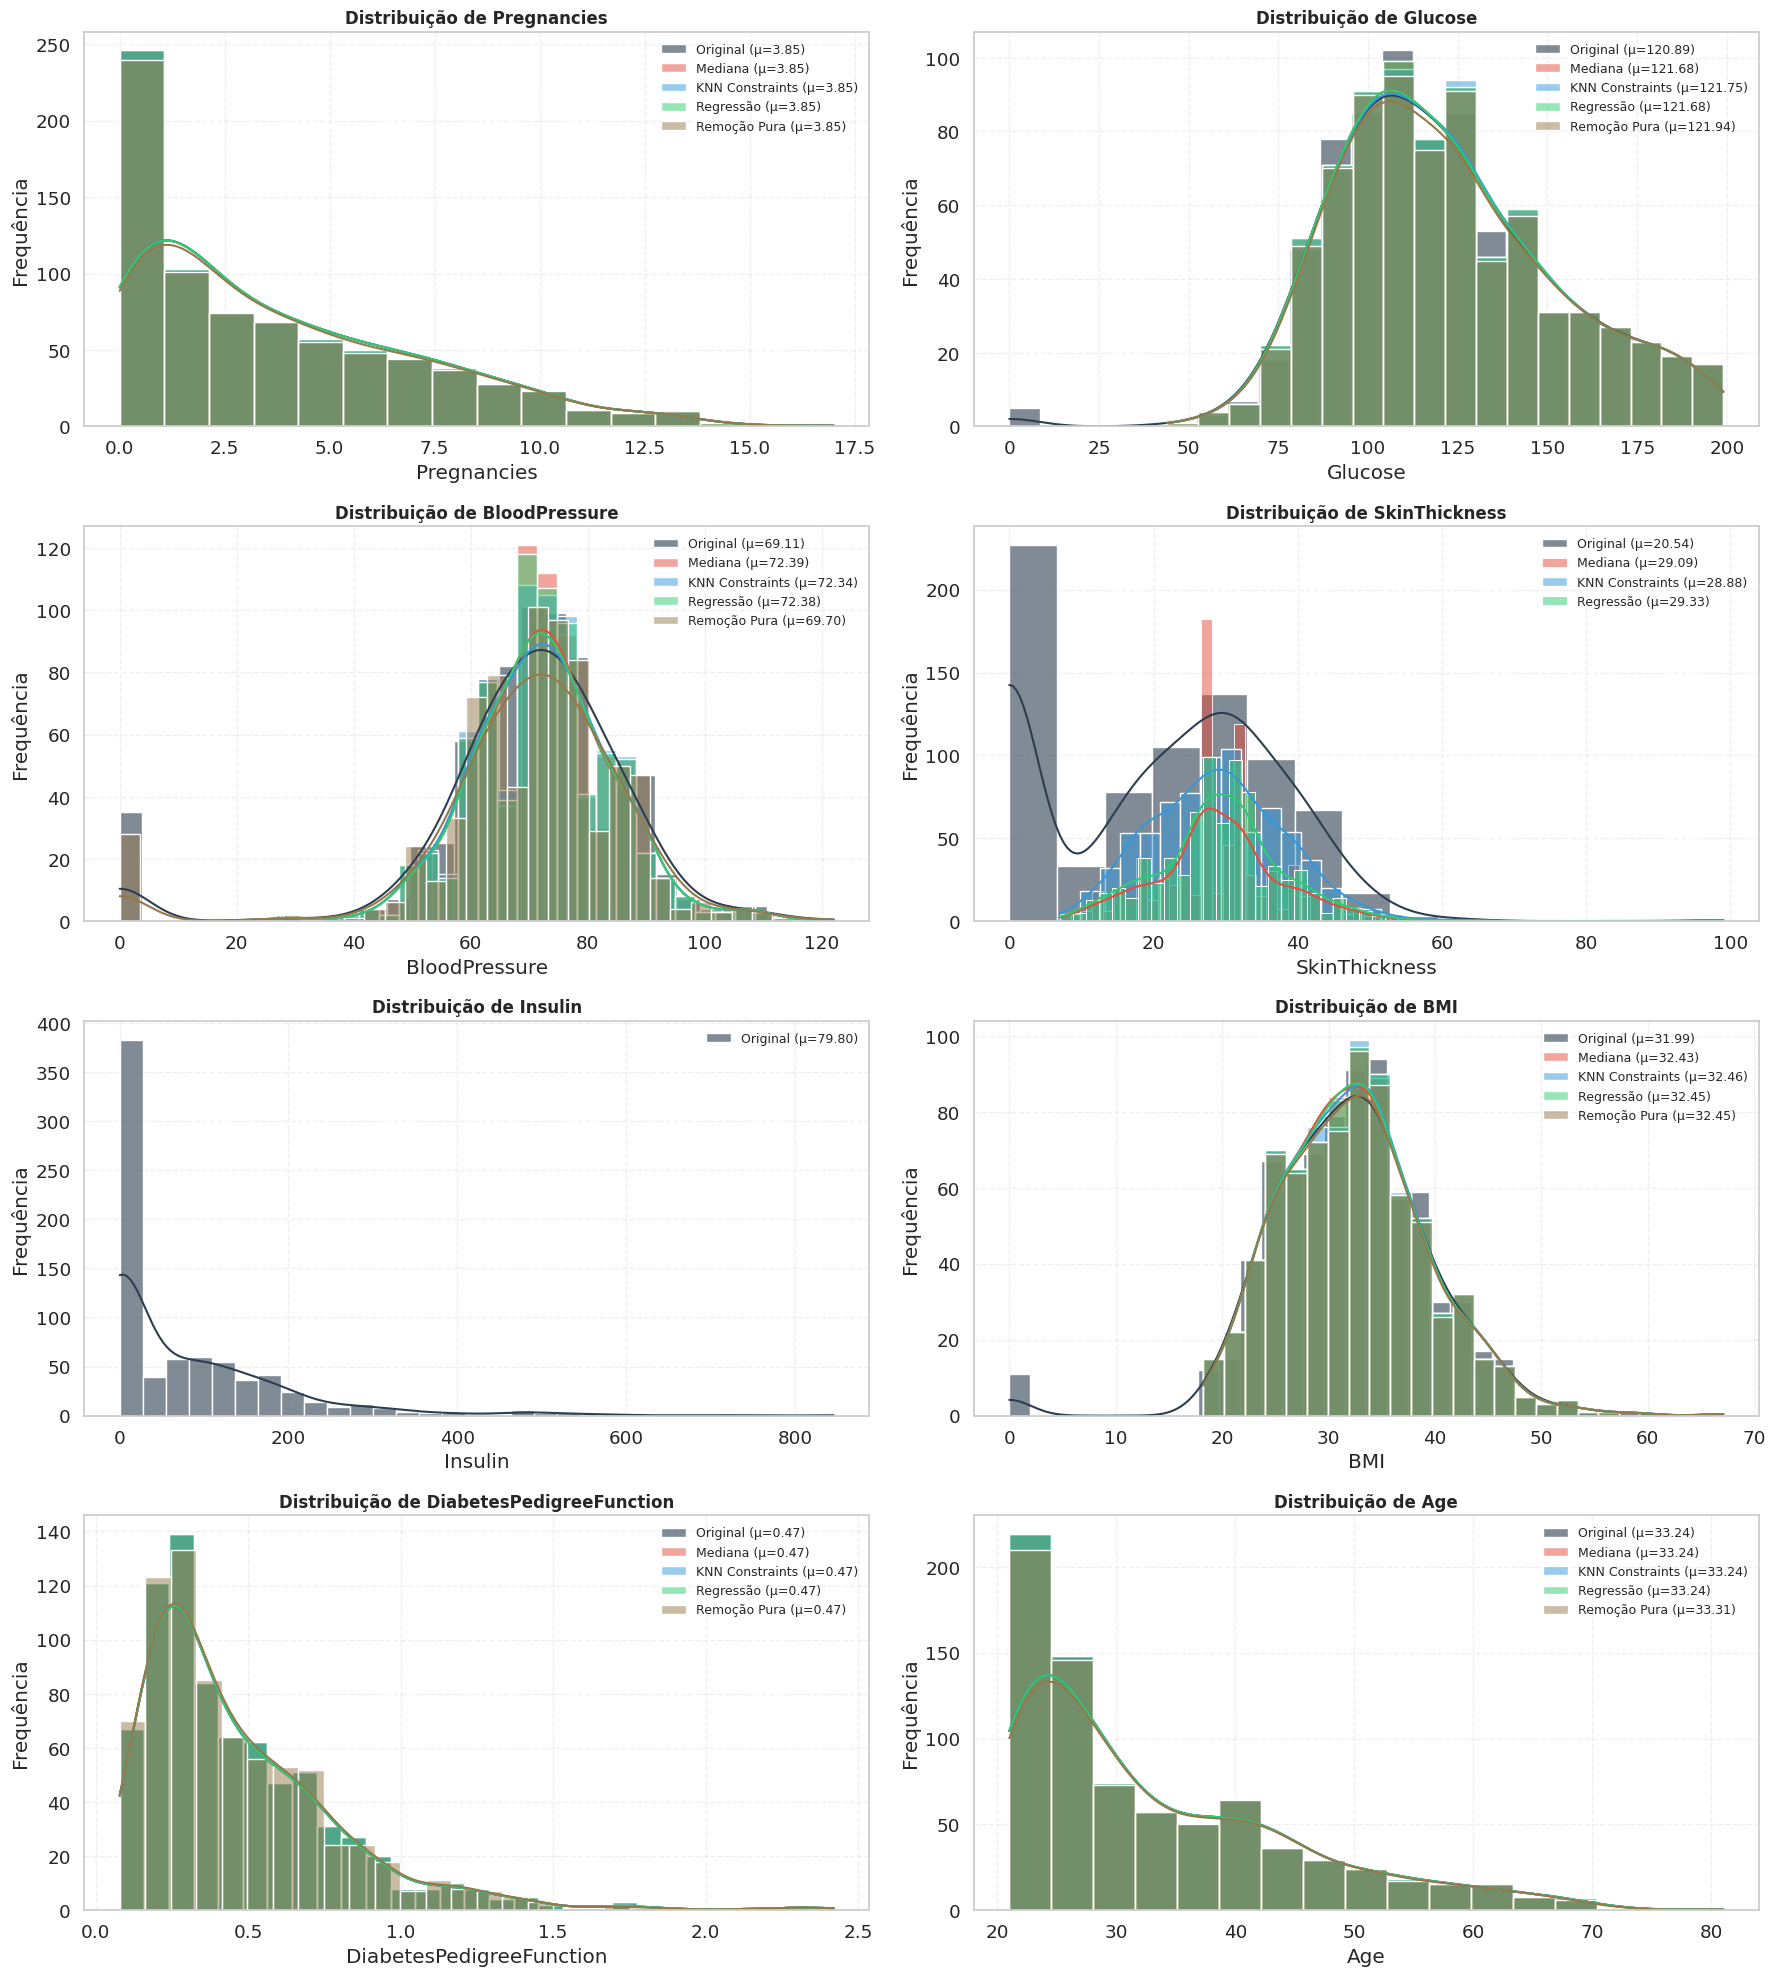

In [8]:
# Visualizar distribuições antes e depois para colunas chave - TODOS OS DATASETS
def plot_distributions_all(datasets_dict, columns=None):
    original_df = datasets_dict['Original']
    
    if columns is None:
        # Usar colunas presentes no dataset original, excluindo 'Outcome'
        columns = [col for col in original_df.columns if col != 'Outcome']
    
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    # Cores para cada dataset
    colors_dist = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', "#96794B54"]
    
    for i, col in enumerate(columns):
        ax = axes[i]
        
        # Plotar histograma para cada dataset que possui a coluna
        for j, (nome, df) in enumerate(datasets_dict.items()):
            if col in df.columns:
                color = colors_dist[j % len(colors_dist)]
                alpha = 0.6 if nome == 'Original' else 0.5
                
                # Calcular média para mostrar na legenda
                media = df[col].mean()
                label = f'{nome} (μ={media:.2f})'
                
                sns.histplot(df[col], color=color, alpha=alpha, 
                           label=label, ax=ax, kde=True)
        
        ax.set_title(f'Distribuição de {col}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    # Ocultar eixos não utilizados
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Visualizar mudanças nas distribuições para todos os datasets
print("\n" + "=" * 80)
print("📊 VISUALIZAÇÃO DAS DISTRIBUIÇÕES - TODOS OS DATASETS")
print("=" * 80)
plot_distributions_all(datasets)


📊 TRANSFORMAÇÃO EM Glucose:
   • Pontos modificados: 5
   • Valores originais (zeros): [0]
   • Valores imputados: [np.float64(107.0), np.float64(140.0)]


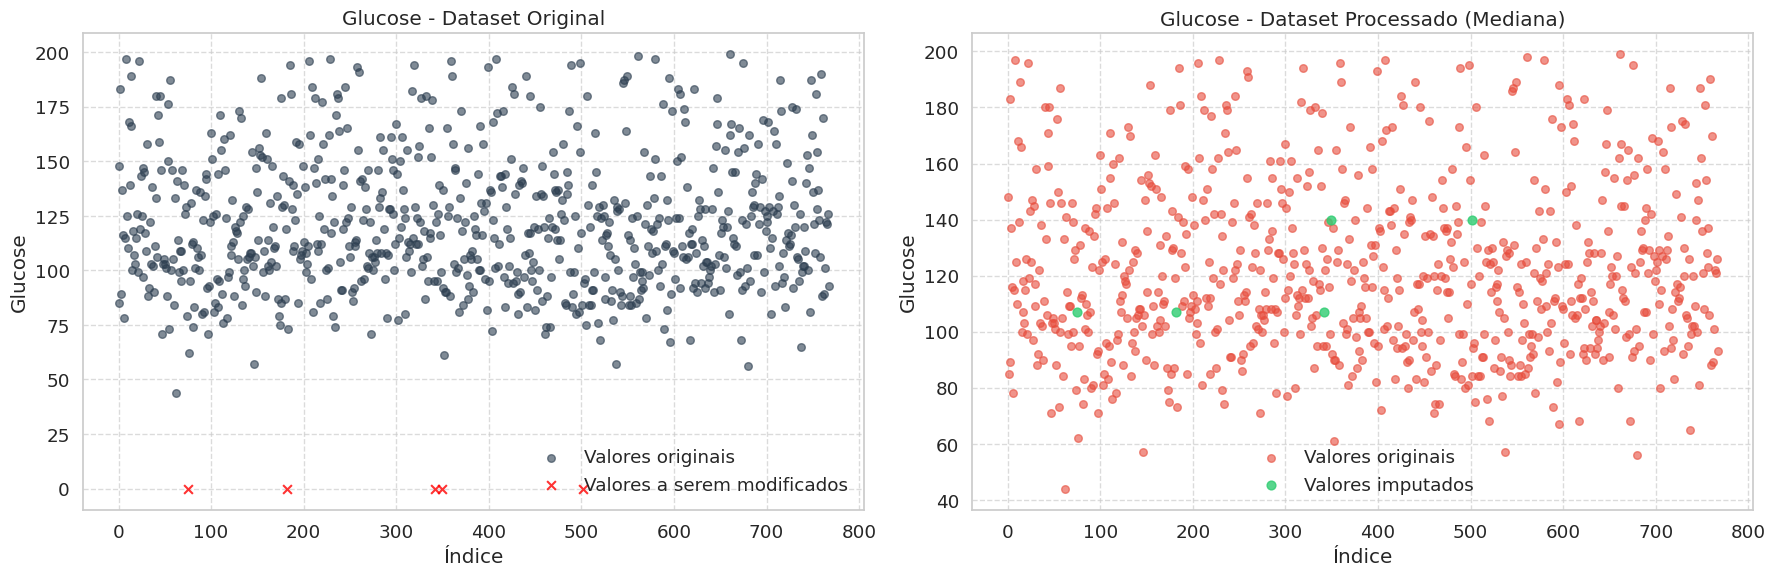


📊 TRANSFORMAÇÃO EM BloodPressure:
   • Pontos modificados: 35
   • Valores originais (zeros): [0]
   • Valores imputados: [np.float64(70.0), np.float64(74.5)]


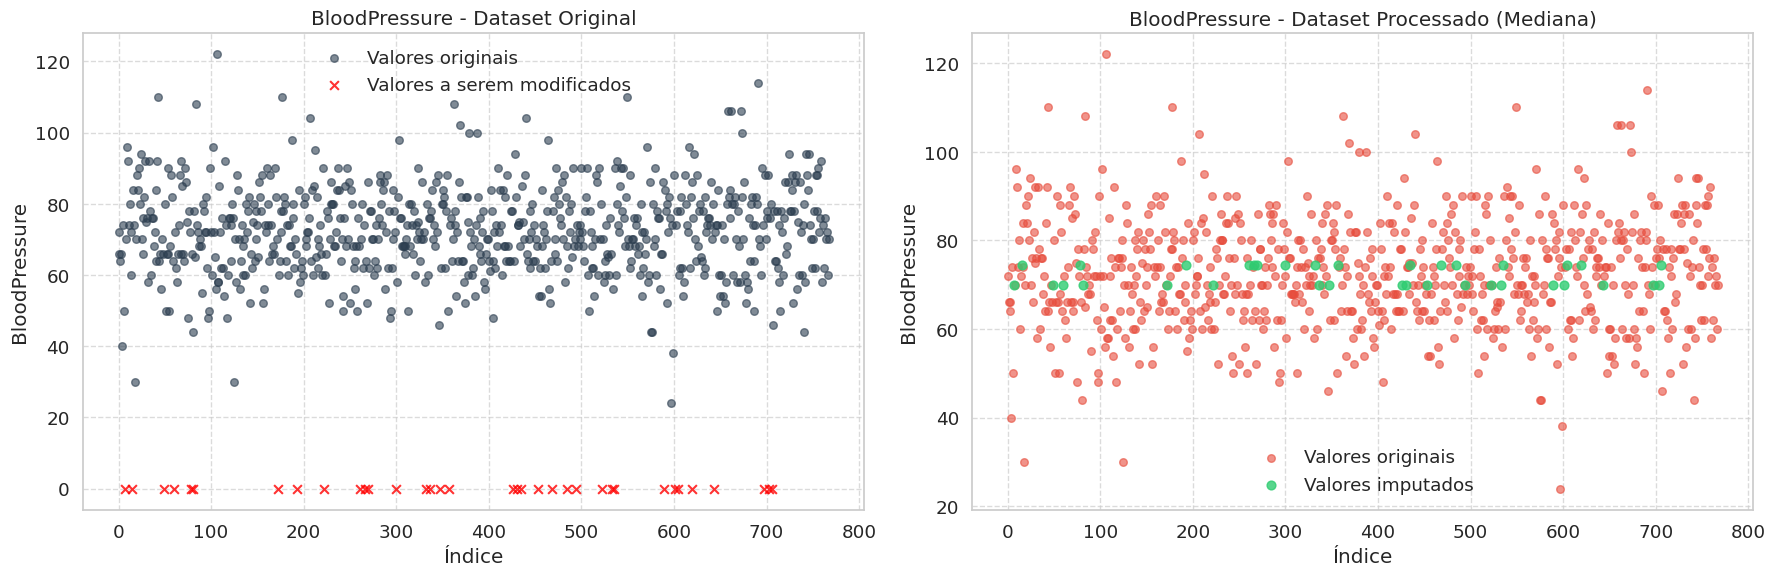


📊 TRANSFORMAÇÃO EM SkinThickness:
   • Pontos modificados: 227
   • Valores originais (zeros): [0]
   • Valores imputados: [np.float64(27.0), np.float64(32.0)]


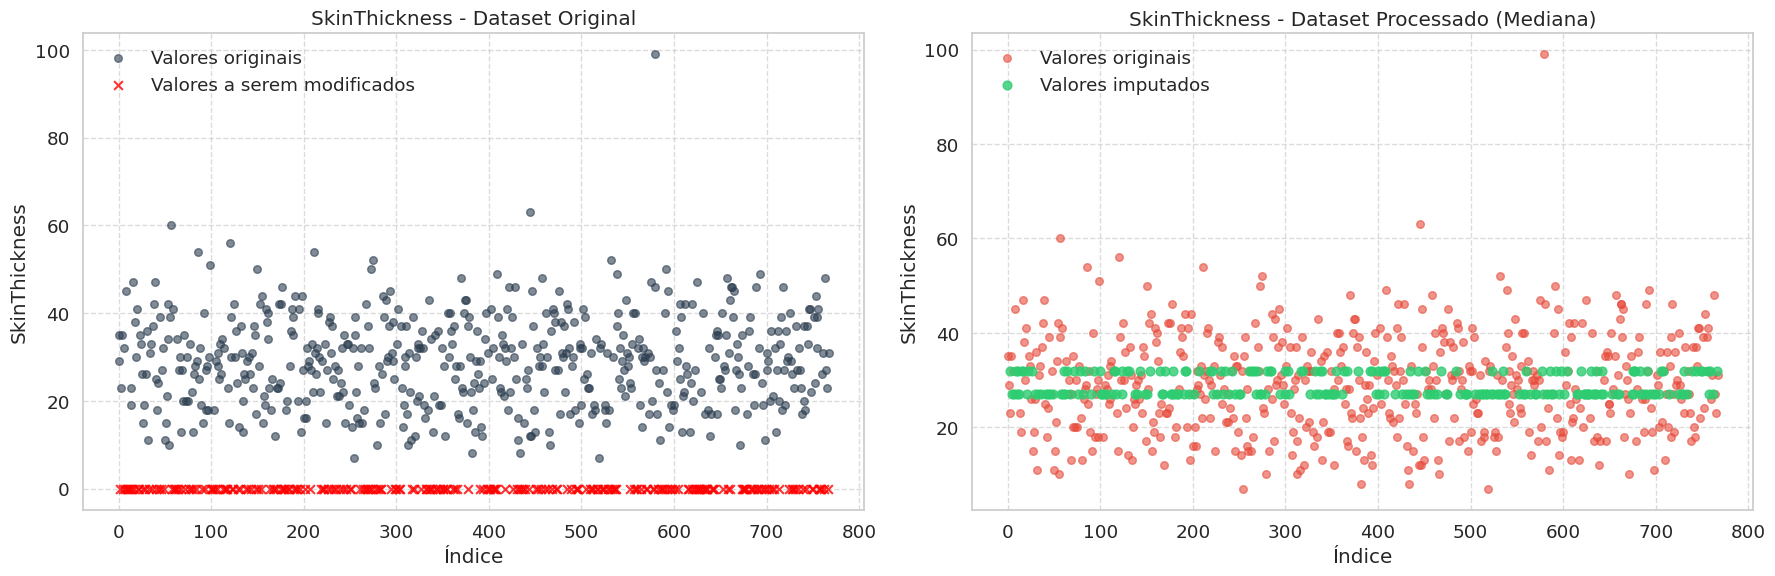


📊 TRANSFORMAÇÃO EM BMI:
   • Pontos modificados: 11
   • Valores originais (zeros): [0.]
   • Valores imputados: [np.float64(30.1), np.float64(34.3)]


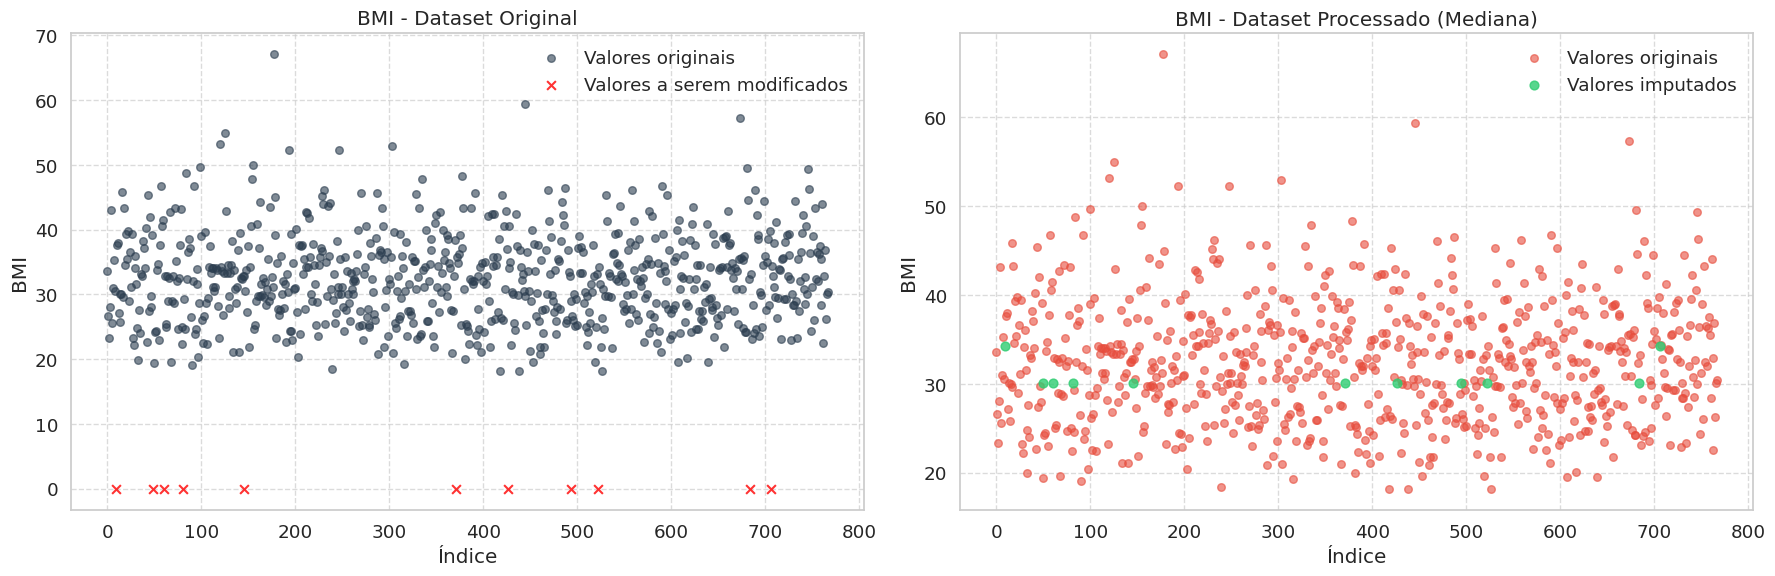


============================== TRANSFORMAÇÃO EM Glucose ==============================


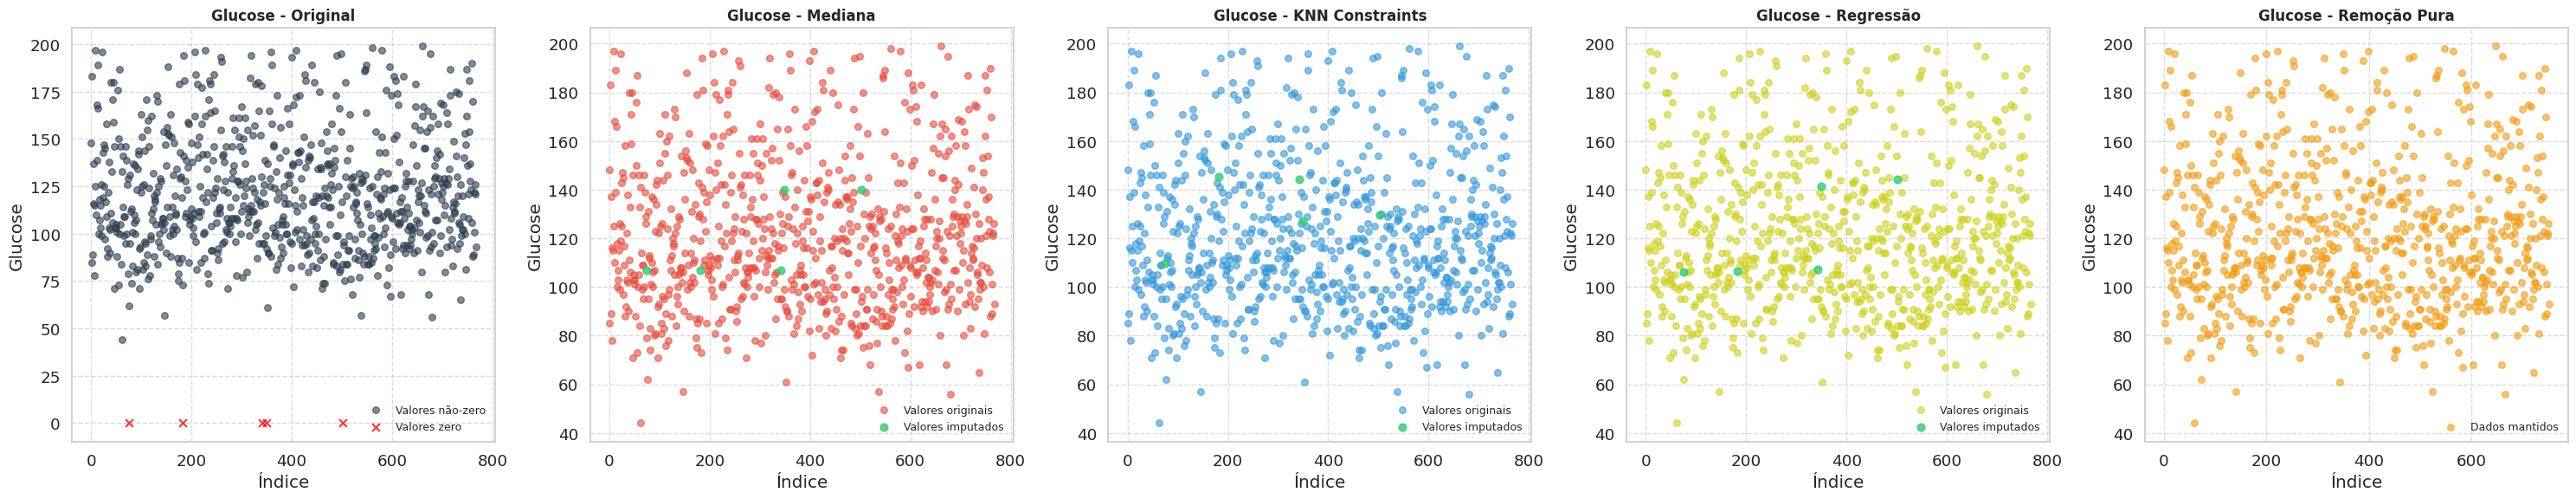


📊 ESTATÍSTICAS COMPARATIVAS PARA Glucose:


Zeros   Média Mediana Desvio
Original             5  120.89  117.00  31.97
Mediana              0  121.68  117.00  30.46
KNN Constraints      0  121.75  117.00  30.46
Regressão            0  121.68  117.00  30.47
Remoção Pura         0  121.94  117.00  30.60


============================== TRANSFORMAÇÃO EM BloodPressure ==============================


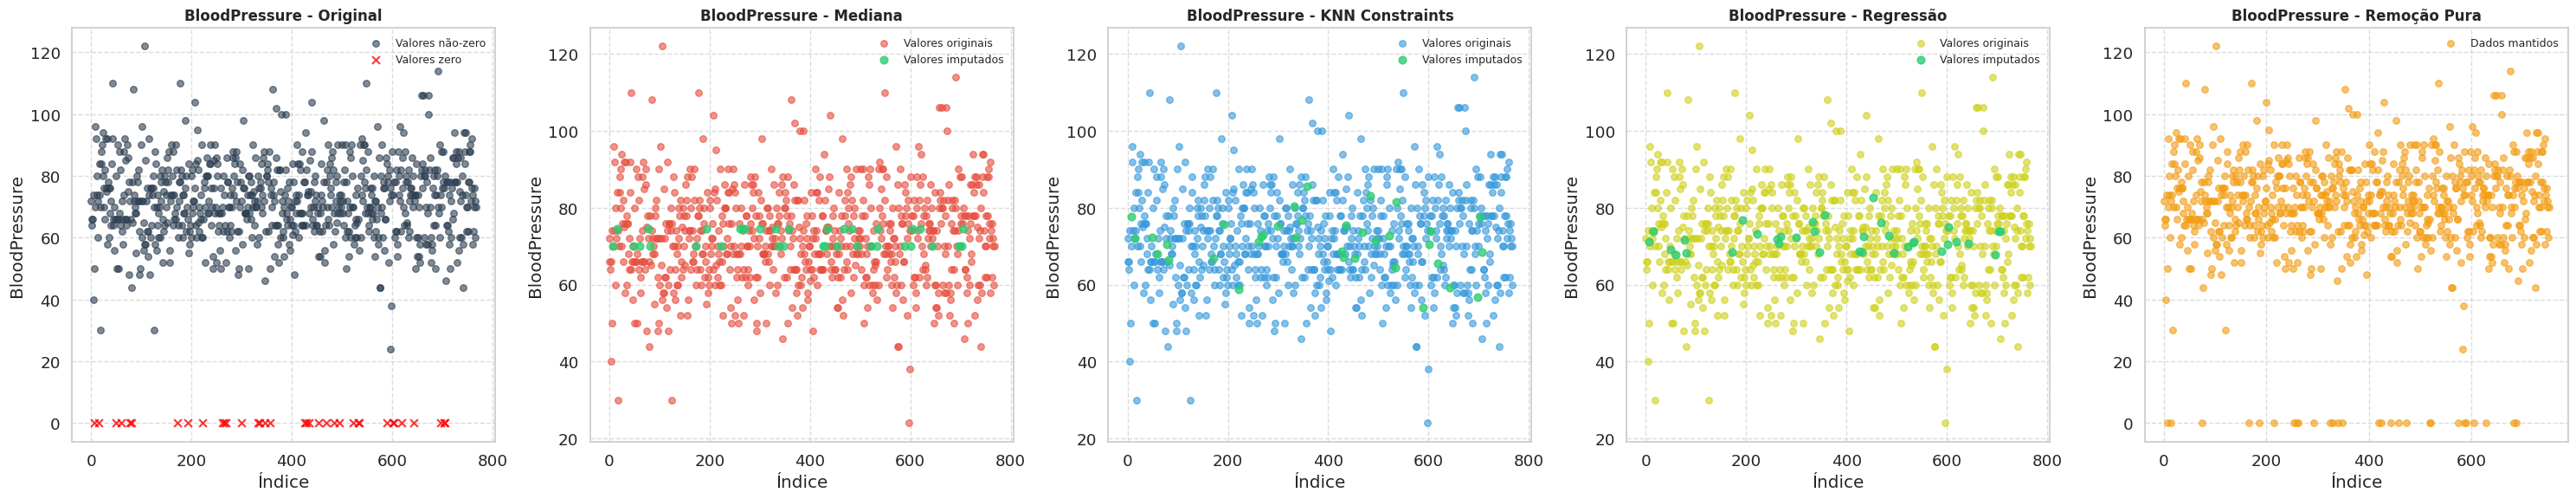


📊 ESTATÍSTICAS COMPARATIVAS PARA BloodPressure:


Zeros  Média Mediana Desvio
Original            35  69.11   72.00  19.36
Mediana              0  72.39   72.00  12.11
KNN Constraints      0  72.34   72.00  12.19
Regressão            0  72.38   72.00  12.12
Remoção Pura        28  69.70   72.00  18.32


============================== TRANSFORMAÇÃO EM SkinThickness ==============================


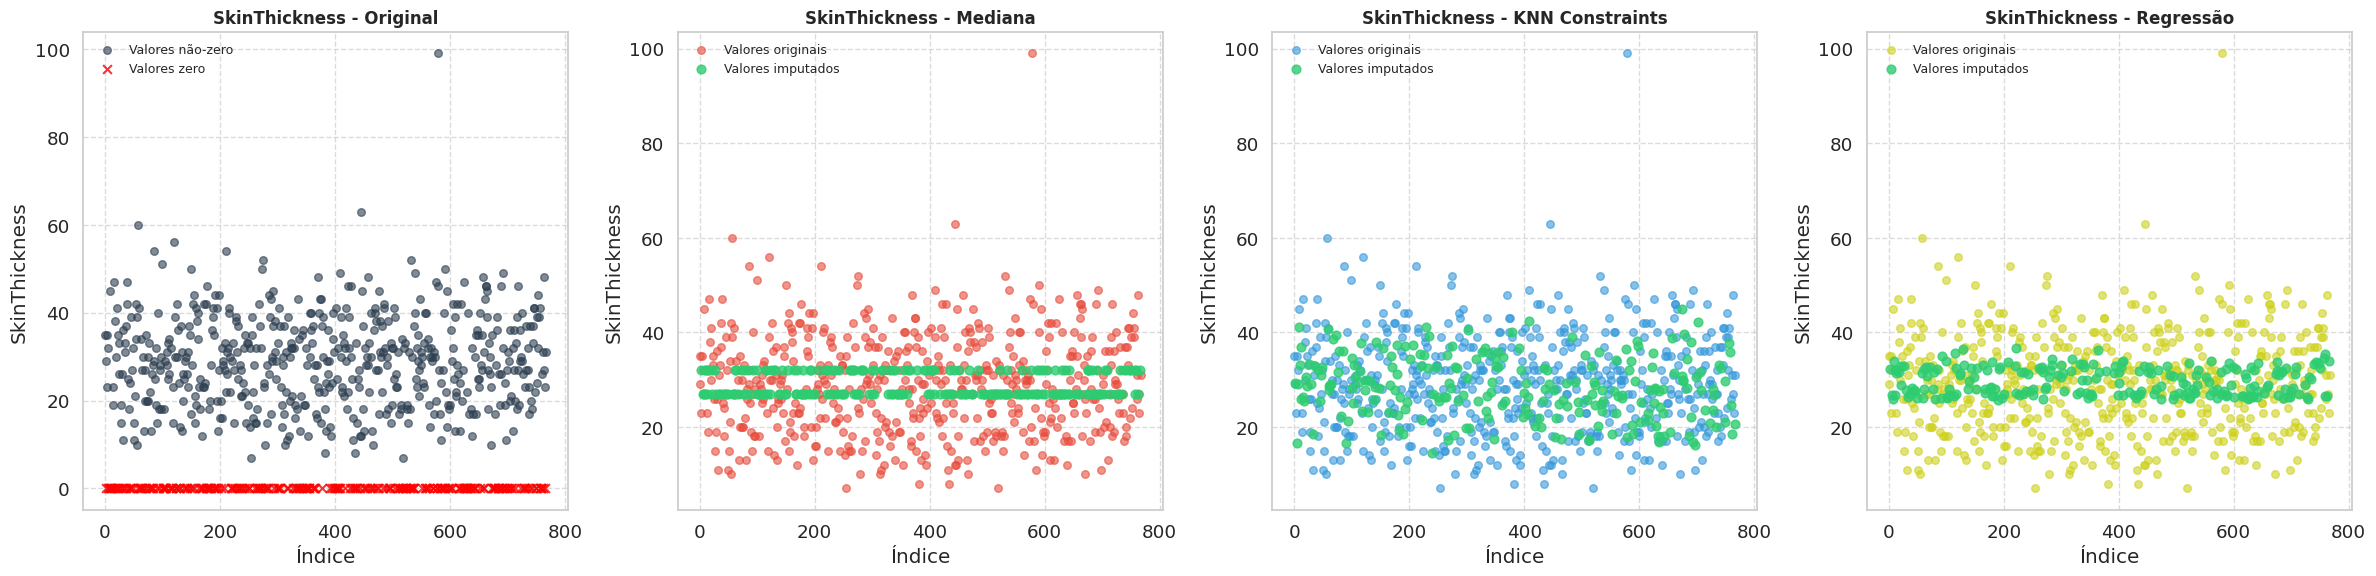


📊 ESTATÍSTICAS COMPARATIVAS PARA SkinThickness:


Zeros  Média Mediana Desvio
Original          227  20.54   23.00  15.95
Mediana             0  29.09   28.00   8.89
KNN Constraints     0  28.88   28.80   9.49
Regressão           0  29.33   29.00   8.93
Remoção Pura      N/A    N/A     N/A    N/A


============================== TRANSFORMAÇÃO EM BMI ==============================


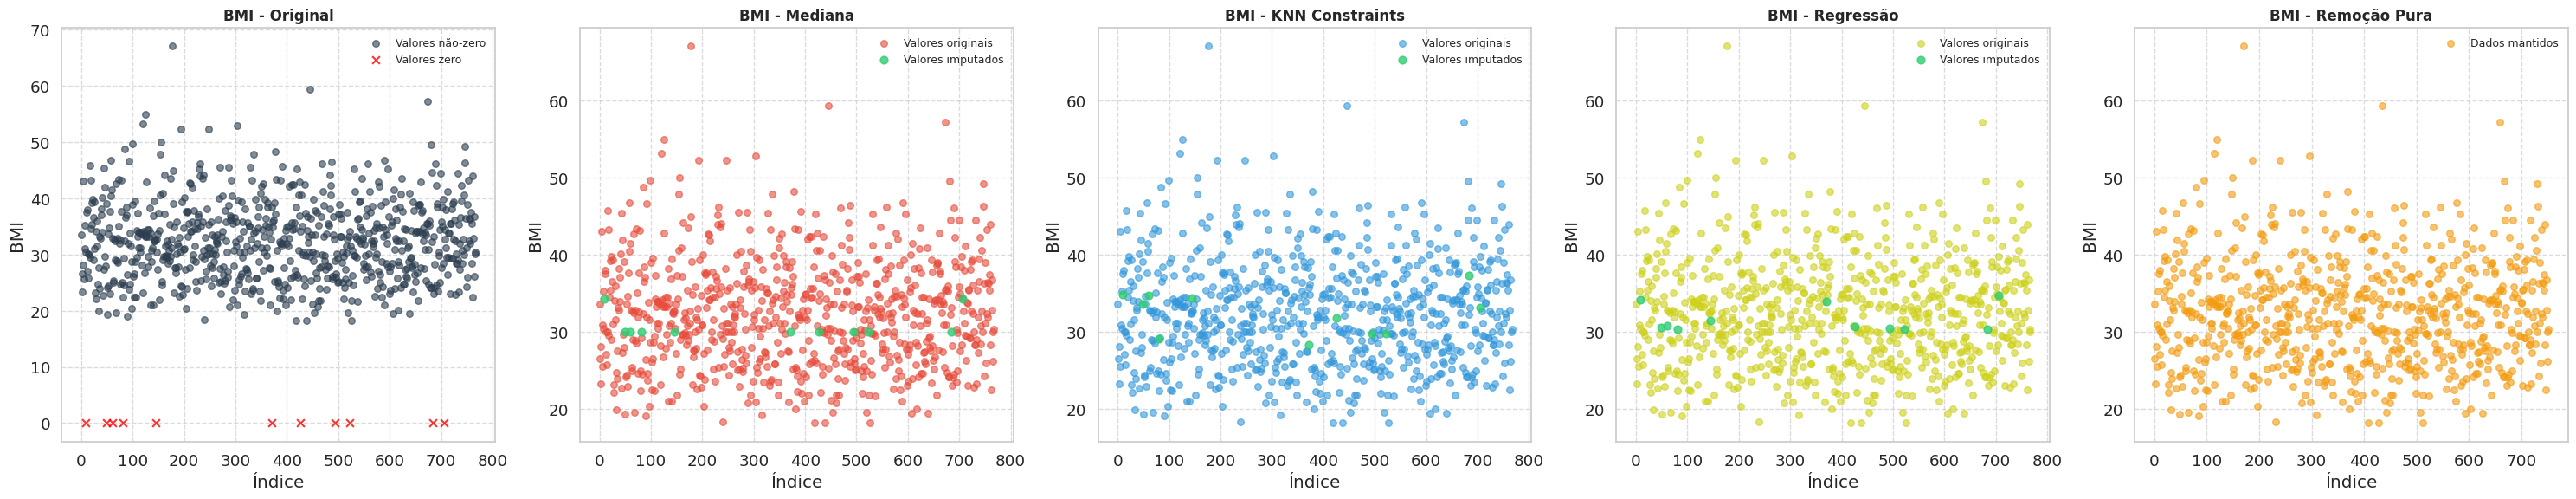


📊 ESTATÍSTICAS COMPARATIVAS PARA BMI:


Zeros  Média Mediana Desvio
Original            11  31.99   32.00   7.88
Mediana              0  32.43   32.05   6.88
KNN Constraints      0  32.46   32.30   6.88
Regressão            0  32.45   32.15   6.88
Remoção Pura         0  32.45   32.30   6.93

In [10]:
# Visualizar o impacto da transformação em variáveis críticas com destaque para pontos modificados
def plot_critical_transformation(original_df, processed_df, col_name):
    if col_name not in processed_df.columns:
        print(f"A coluna {col_name} não existe no dataset processado.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Identificar pontos que foram modificados
    modified_mask = original_df[col_name] != processed_df[col_name]
    
    # Dataset original
    # Pontos não modificados
    axes[0].scatter(original_df[~modified_mask].index, original_df[~modified_mask][col_name], 
                   alpha=0.6, color=colors[0], label='Valores originais', s=30)
    # Pontos que serão modificados (destacados em vermelho)
    axes[0].scatter(original_df[modified_mask].index, original_df[modified_mask][col_name], 
                   alpha=0.8, color='red', label='Valores a serem modificados', s=40, marker='x')
    
    axes[0].set_title(f'{col_name} - Dataset Original')
    axes[0].set_ylabel(col_name)
    axes[0].set_xlabel('Índice')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # Dataset processado
    # Pontos não modificados
    axes[1].scatter(processed_df[~modified_mask].index, processed_df[~modified_mask][col_name], 
                   alpha=0.6, color=colors[1], label='Valores originais', s=30)
    # Pontos modificados (destacados em verde)
    axes[1].scatter(processed_df[modified_mask].index, processed_df[modified_mask][col_name], 
                   alpha=0.8, color='#2ECC71', label='Valores imputados', s=40, marker='o')
    
    axes[1].set_title(f'{col_name} - Dataset Processado (Mediana)')
    axes[1].set_ylabel(col_name)
    axes[1].set_xlabel('Índice')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Mostrar estatísticas dos pontos modificados
    if modified_mask.sum() > 0:
        print(f"   • Pontos modificados: {modified_mask.sum()}")
        print(f"   • Valores originais (zeros): {original_df[modified_mask][col_name].unique()}")
        print(f"   • Valores imputados: {sorted(processed_df[modified_mask][col_name].unique())}")
    
    plt.tight_layout()
    plt.show()

# Visualizar o impacto da transformação em variáveis críticas para todos os datasets
def plot_critical_transformation_all(datasets_dict, col_name):
    original_df = datasets_dict['Original']
    
    # Verificar quantos datasets têm a coluna
    datasets_with_col = {nome: df for nome, df in datasets_dict.items() 
                        if col_name in df.columns}
    
    if len(datasets_with_col) <= 1:
        print(f"A coluna {col_name} existe em poucos datasets para comparação.")
        return
    
    n_datasets = len(datasets_with_col)
    fig, axes = plt.subplots(1, n_datasets, figsize=(6*n_datasets, 6))
    if n_datasets == 1:
        axes = [axes]
    
    colors_scatter = ['#2C3E50', '#E74C3C', '#3498DB', "#CED11B", '#F39C12']
    
    for idx, (nome, df) in enumerate(datasets_with_col.items()):
        ax = axes[idx]
        
        if nome == 'Original':
            # Para o original, destacar zeros
            non_zero_mask = df[col_name] != 0
            zero_mask = df[col_name] == 0
            
            if non_zero_mask.sum() > 0:
                ax.scatter(df[non_zero_mask].index, df[non_zero_mask][col_name], 
                          alpha=0.6, color=colors_scatter[idx], label='Valores não-zero', s=30)
            if zero_mask.sum() > 0:
                ax.scatter(df[zero_mask].index, df[zero_mask][col_name], 
                          alpha=0.8, color='red', label='Valores zero', s=40, marker='x')
        else:
            # Para datasets processados, comparar com original
            if 'Remoção Pura' in nome:
                # Para remoção pura, mostrar apenas os dados restantes
                ax.scatter(df.index, df[col_name], alpha=0.6, color=colors_scatter[idx], 
                          label='Dados mantidos', s=30)
            else:
                # Para outros métodos, destacar valores imputados
                original_zeros = original_df[col_name] == 0
                
                # Valores que não eram zero originalmente
                non_modified = df.index[~original_zeros[:len(df)]]
                if len(non_modified) > 0:
                    ax.scatter(non_modified, df.loc[non_modified, col_name], 
                              alpha=0.6, color=colors_scatter[idx], label='Valores originais', s=30)
                
                # Valores que foram imputados (eram zero no original)
                modified_indices = df.index[original_zeros[:len(df)]]
                if len(modified_indices) > 0:
                    ax.scatter(modified_indices, df.loc[modified_indices, col_name], 
                              alpha=0.8, color='#2ECC71', label='Valores imputados', s=40, marker='o')
        
        ax.set_title(f'{col_name} - {nome}', fontsize=12, fontweight='bold')
        ax.set_ylabel(col_name)
        ax.set_xlabel('Índice')
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estatísticas comparativas
    print(f"\n📊 ESTATÍSTICAS COMPARATIVAS PARA {col_name}:")
    stats_comparison = pd.DataFrame({
        'Zeros': [((df[col_name] == 0).sum() if col_name in df.columns else 'N/A') 
                 for df in datasets_dict.values()],
        'Média': [(df[col_name].mean() if col_name in df.columns else 'N/A') 
                 for df in datasets_dict.values()],
        'Mediana': [(df[col_name].median() if col_name in df.columns else 'N/A') 
                   for df in datasets_dict.values()],
        'Desvio': [(df[col_name].std() if col_name in df.columns else 'N/A') 
                  for df in datasets_dict.values()]
    }, index=datasets_dict.keys())
    
    # Formatar valores numéricos
    for col in ['Média', 'Mediana', 'Desvio']:
        stats_comparison[col] = stats_comparison[col].apply(
            lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x
        )
    
    display(stats_comparison)

# Visualizar transformações em variáveis específicas
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

for var in critical_vars:
    print(f"\n📊 TRANSFORMAÇÃO EM {var}:")
    plot_critical_transformation(df_original, df_mediana, var)

# Visualizar transformações em variáveis específicas para todos os datasets
critical_vars = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

for var in critical_vars:
    print(f"\n{'='*30} TRANSFORMAÇÃO EM {var} {'='*30}")
    plot_critical_transformation_all(datasets, var)

## 5. Análise de Impacto em Outliers


📊 ANÁLISE DE OUTLIERS


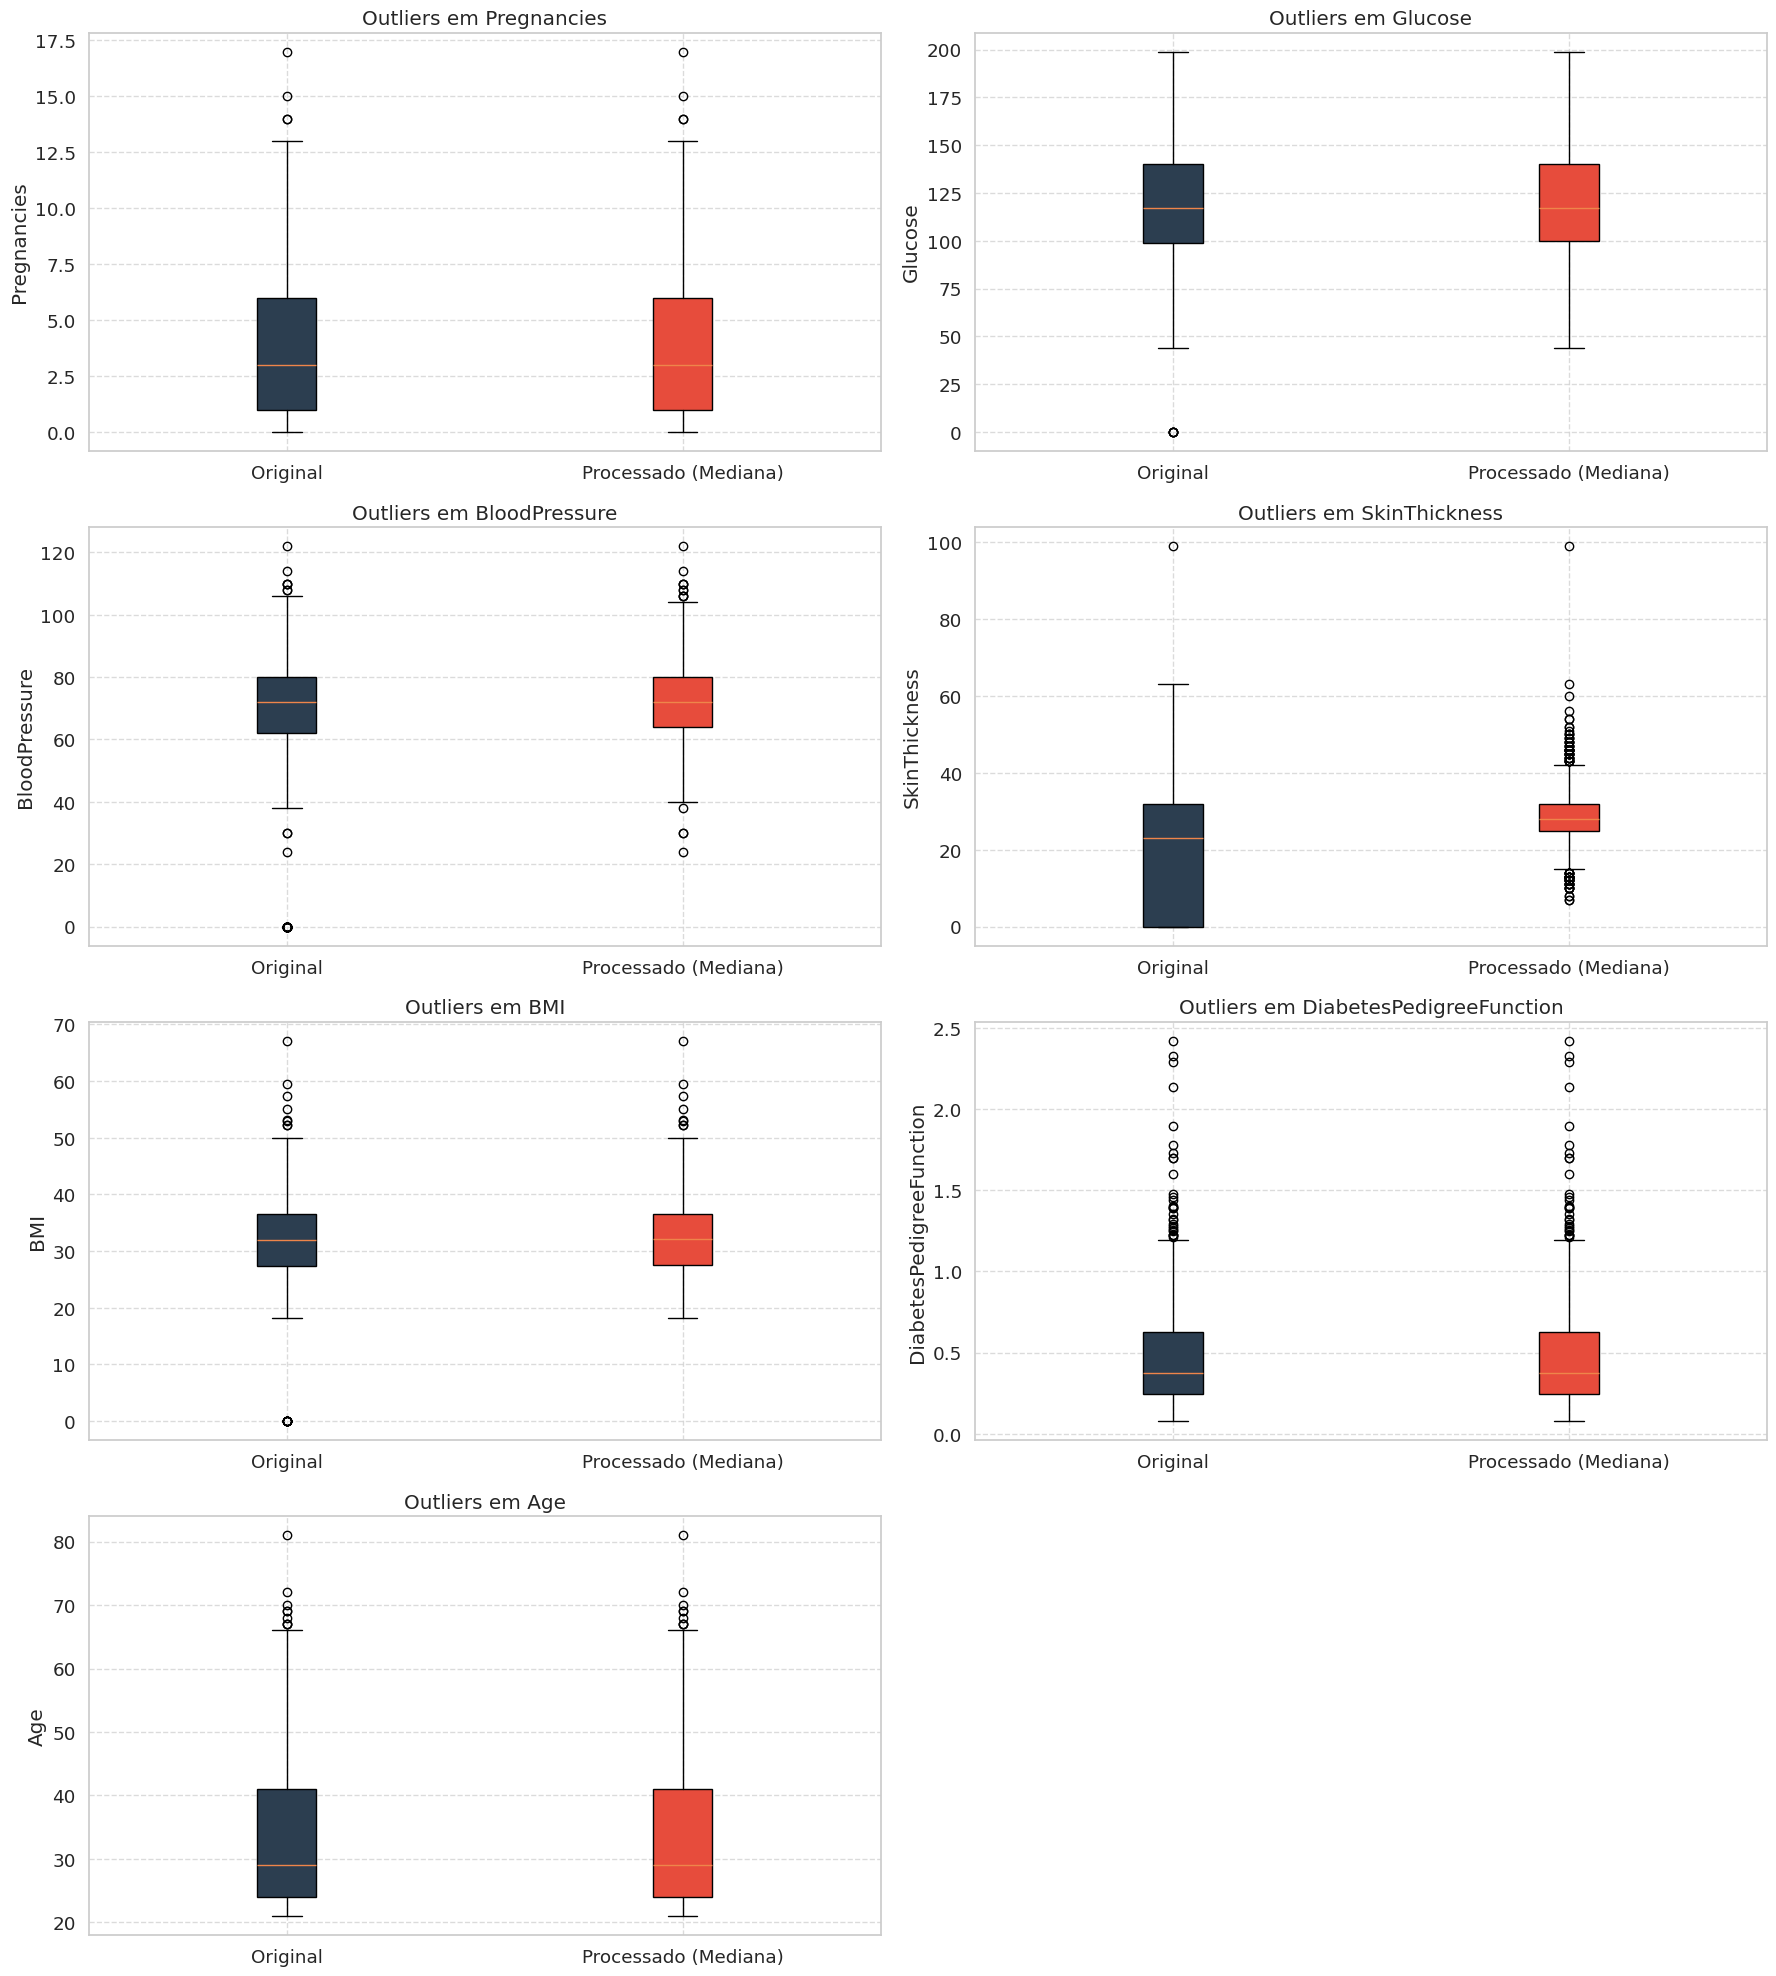


📊 ANÁLISE DE OUTLIERS - TODOS OS DATASETS


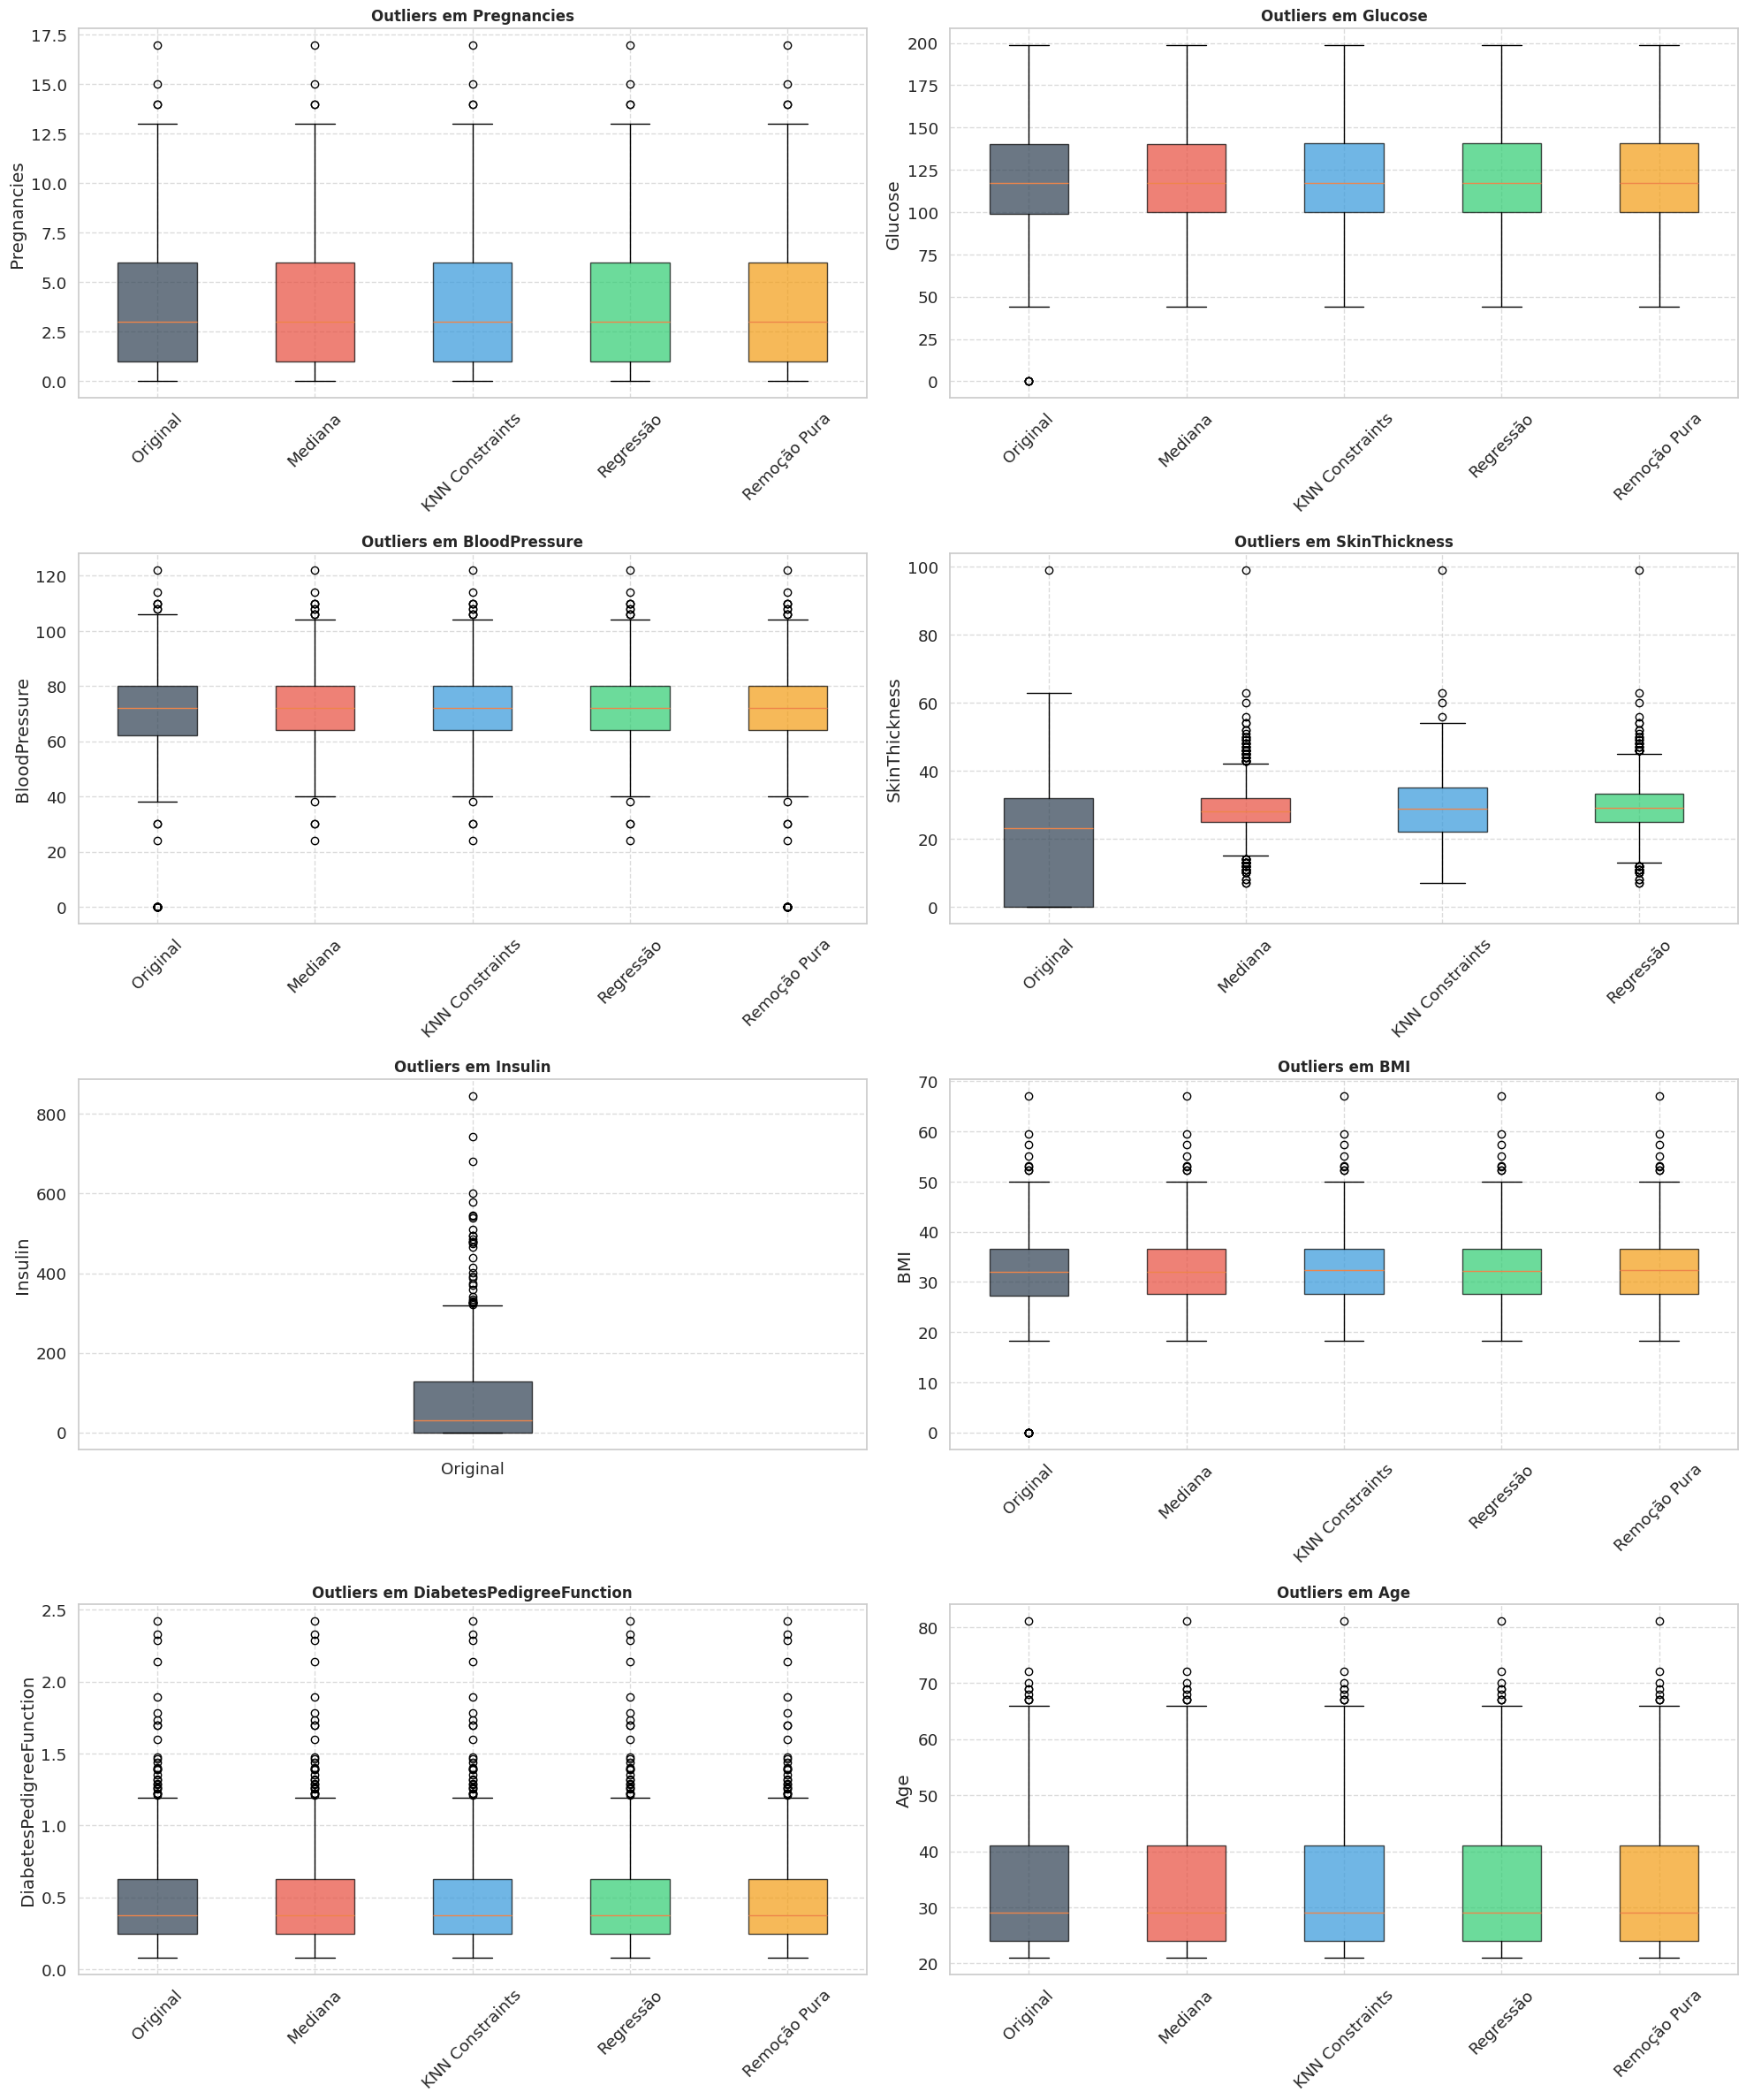


📊 CONTAGEM DE OUTLIERS POR DATASET (usando IQR):


Pregnancies  Glucose  BloodPressure SkinThickness Insulin  \
Original                   4        5             45             1      34   
Mediana                    4        0             14            87     N/A   
KNN Constraints            4        0             14             4     N/A   
Regressão                  4        0             14            53     N/A   
Remoção Pura               4        0             42           N/A     N/A   

                 BMI  DiabetesPedigreeFunction  Age  
Original          19                        29    9  
Mediana            8                        29    9  
KNN Constraints    8                        29    9  
Regressão          8                        29    9  
Remoção Pura       8                        28    8

In [56]:
# Analisar outliers antes e depois
def plot_boxplots(original_df, processed_df):
    # Encontrar colunas compartilhadas, excluindo 'Outcome'
    shared_columns = [col for col in original_df.columns if col in processed_df.columns and col != 'Outcome']
    
    n_cols = 2
    n_rows = (len(shared_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(shared_columns):
        ax = axes[i]
        
        # Preparar dados para boxplot
        data = [
            original_df[col].values,
            processed_df[col].values
        ]
        
        # Criar boxplot
        bp = ax.boxplot(data, patch_artist=True, labels=['Original', 'Processado (Mediana)'])
        
        # Colorir boxplots
        for patch, color in zip(bp['boxes'], [colors[0], colors[1]]):
            patch.set_facecolor(color)
        
        ax.set_title(f'Outliers em {col}')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel(col)
    
    # Ocultar eixos não utilizados
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 60)
print("📊 ANÁLISE DE OUTLIERS")
print("=" * 60)
plot_boxplots(df_original, df_mediana)

# Analisar outliers em todos os datasets
def plot_boxplots_all(datasets_dict):
    # Encontrar colunas compartilhadas (pelo menos no original)
    original_columns = [col for col in datasets_dict['Original'].columns if col != 'Outcome']
    
    n_cols = 2
    n_rows = (len(original_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    colors_box = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
    
    for i, col in enumerate(original_columns):
        ax = axes[i]
        
        # Preparar dados para boxplot apenas dos datasets que têm a coluna
        data = []
        labels = []
        colors_current = []
        
        for j, (nome, df) in enumerate(datasets_dict.items()):
            if col in df.columns:
                data.append(df[col].values)
                labels.append(nome)
                colors_current.append(colors_box[j % len(colors_box)])
        
        if len(data) > 0:
            # Criar boxplot
            bp = ax.boxplot(data, patch_artist=True, labels=labels)
            
            # Colorir boxplots
            for patch, color in zip(bp['boxes'], colors_current):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
        
        ax.set_title(f'Outliers em {col}', fontsize=12, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_ylabel(col)
        
        # Rotacionar labels se necessário
        if len(labels) > 3:
            ax.tick_params(axis='x', rotation=45)
    
    # Ocultar eixos não utilizados
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("📊 ANÁLISE DE OUTLIERS - TODOS OS DATASETS")
print("=" * 80)
plot_boxplots_all(datasets)

# Análise quantitativa de outliers
print("\n📊 CONTAGEM DE OUTLIERS POR DATASET (usando IQR):")
outlier_counts = pd.DataFrame(index=datasets.keys())

for col in df_original.columns:
    if col == 'Outcome':
        continue
        
    outlier_count_col = []
    for nome, df in datasets.items():
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_count_col.append(outliers)
        else:
            outlier_count_col.append('N/A')
    
    outlier_counts[col] = outlier_count_col

display(outlier_counts)

## 6. Análise de Correlações e Impacto nas Relações Entre Variáveis


📊 ANÁLISE DE CORRELAÇÕES


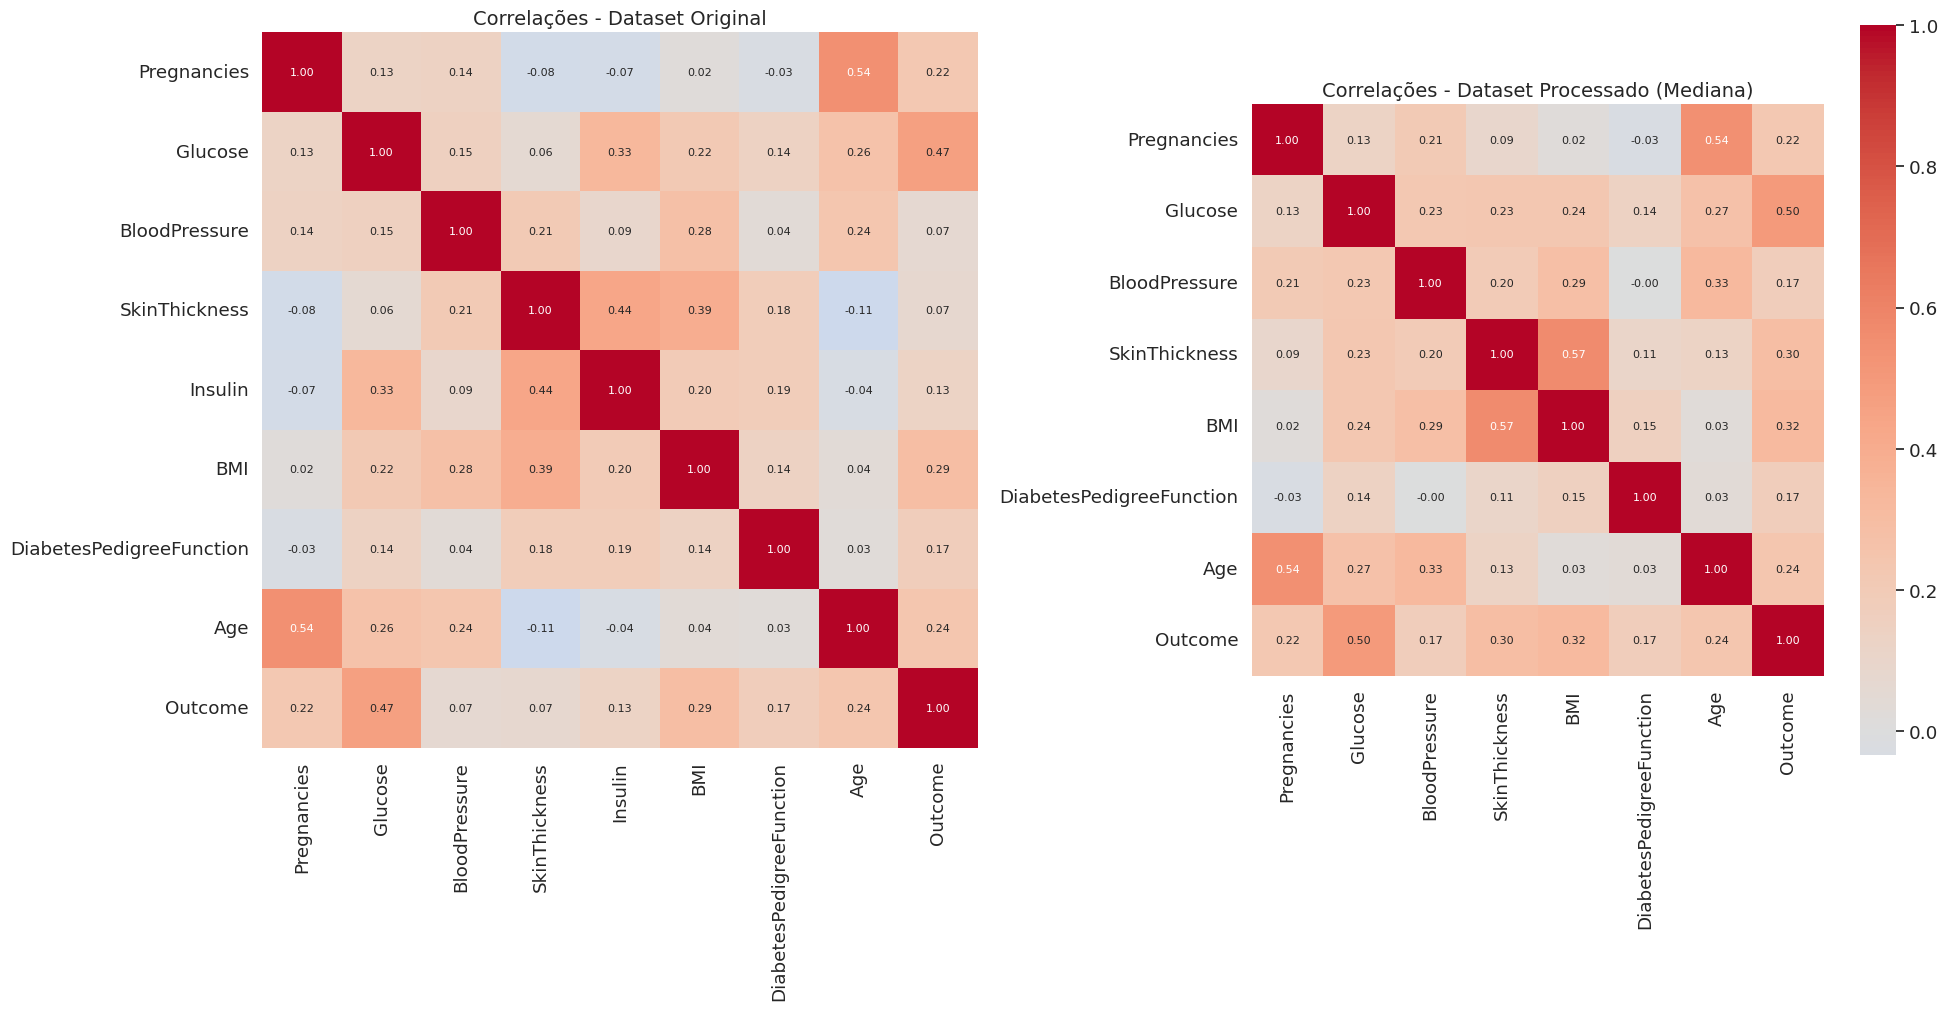


📊 MUDANÇAS NAS CORRELAÇÕES COM A VARIÁVEL TARGET:


Original  Processado  Diferença
SkinThickness             0.074752    0.295138   0.220385
BloodPressure             0.065068    0.174469   0.109400
Glucose                   0.466581    0.495990   0.029409
BMI                       0.292695    0.315577   0.022882
DiabetesPedigreeFunction  0.173844    0.173844   0.000000
Age                       0.238356    0.238356   0.000000
Outcome                   1.000000    1.000000   0.000000
Pregnancies               0.221898    0.221898   0.000000
Insulin                   0.130548         NaN        NaN


📊 ANÁLISE DE CORRELAÇÕES - TODOS OS DATASETS


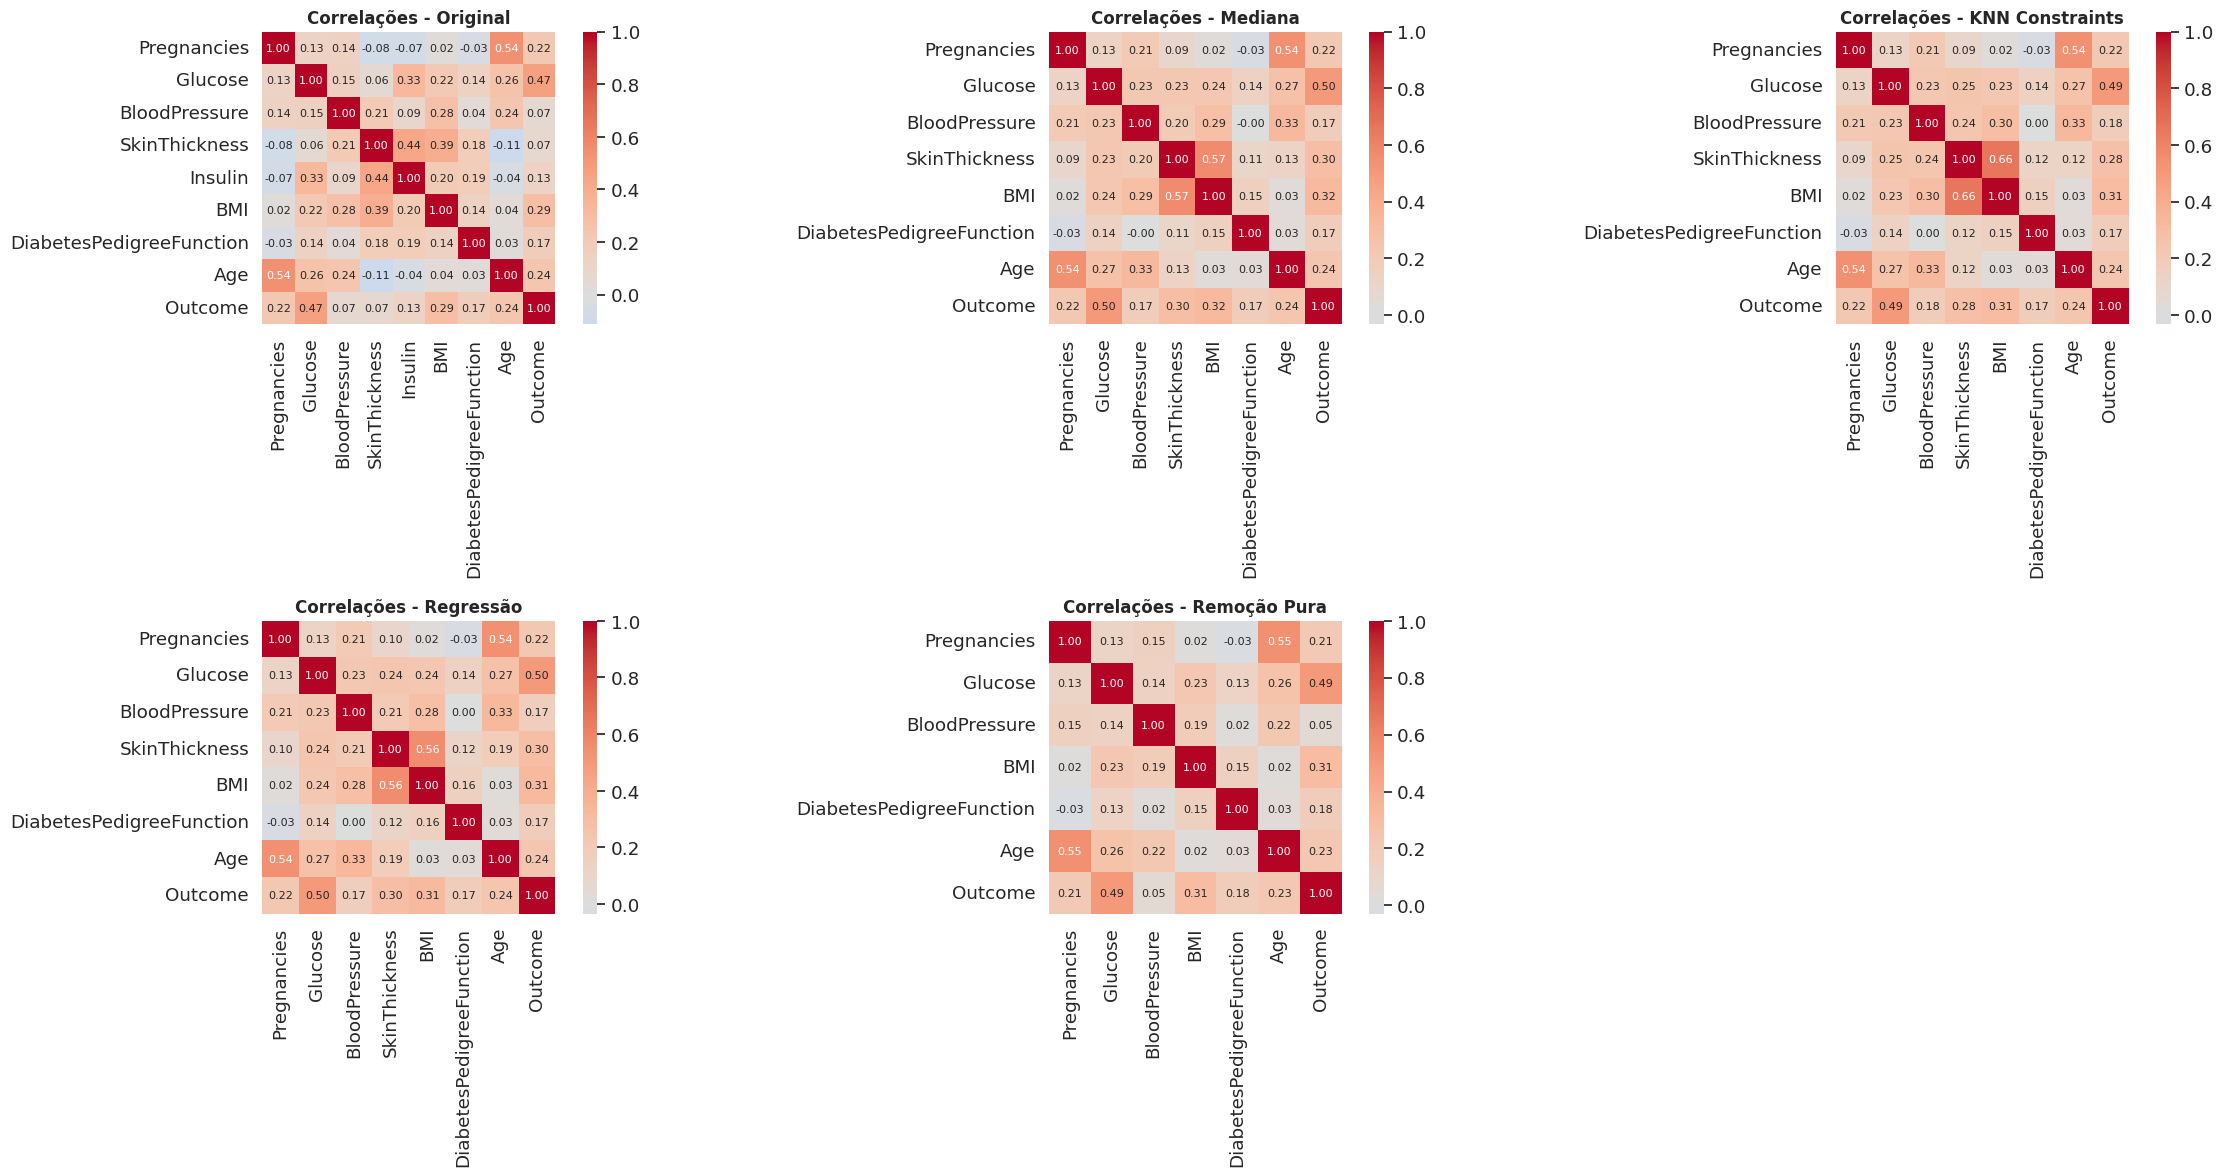


📊 MUDANÇAS NAS CORRELAÇÕES COM A VARIÁVEL TARGET (OUTCOME):


Original  Mediana  KNN Constraints  Regressão  \
Glucose                     0.4666   0.4960           0.4922     0.4963   
BMI                         0.2927   0.3156           0.3128     0.3146   
Age                         0.2384   0.2384           0.2384     0.2384   
Pregnancies                 0.2219   0.2219           0.2219     0.2219   
DiabetesPedigreeFunction    0.1738   0.1738           0.1738     0.1738   
Insulin                     0.1305      NaN              NaN        NaN   
SkinThickness               0.0748   0.2951           0.2770     0.2963   
BloodPressure               0.0651   0.1745           0.1773     0.1711   

                          Remoção Pura  Δ_Mediana  Δ_KNN Constraints  \
Glucose                         0.4942     0.0294             0.0256   
BMI                             0.3099     0.0229             0.0201   
Age                             0.2327     0.0000             0.0000   
Pregnancies                     0.2134     0.0000             0.0000   
DiabetesPedigreeFunction        0.1781     0.0000             0.0000   
Insulin                            NaN        NaN                NaN   
SkinThickness                      NaN     0.2204             0.2023   
BloodPressure                   0.0510     0.1094             0.1122   

                          Δ_Regressão  Δ_Remoção Pura  
Glucose                        0.0297          0.0276  
BMI                            0.0219          0.0172  
Age                            0.0000         -0.0056  
Pregnancies                    0.0000         -0.0085  
DiabetesPedigreeFunction       0.0000          0.0042  
Insulin                           NaN             NaN  
SkinThickness                  0.2216             NaN  
BloodPressure                  0.1061         -0.0141


📊 MAIORES MUDANÇAS EM CORRELAÇÃO (em relação ao original):

   Mediana:
   • Maior aumento: SkinThickness (+0.2204)
   • Maior diminuição: Age (0.0000)

   KNN Constraints:
   • Maior aumento: SkinThickness (+0.2023)
   • Maior diminuição: Age (0.0000)

   Regressão:
   • Maior aumento: SkinThickness (+0.2216)
   • Maior diminuição: Age (0.0000)

   Remoção Pura:
   • Maior aumento: Glucose (+0.0276)
   • Maior diminuição: DiabetesPedigreeFunction (0.0042)


In [57]:
# Analisar correlações antes e depois
def plot_correlation_heatmaps(original_df, processed_df):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Correlações do dataset original
    corr_orig = original_df.corr()
    sns.heatmap(corr_orig, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
               ax=axes[0], cbar=False, square=True, annot_kws={"size": 8})
    axes[0].set_title('Correlações - Dataset Original', fontsize=14)
    
    # Correlações do dataset processado
    corr_proc = processed_df.corr()
    sns.heatmap(corr_proc, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
               ax=axes[1], cbar=True, square=True, annot_kws={"size": 8})
    axes[1].set_title('Correlações - Dataset Processado (Mediana)', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Retornar as correlações para análise
    return corr_orig, corr_proc

print("\n" + "=" * 60)
print("📊 ANÁLISE DE CORRELAÇÕES")
print("=" * 60)
corr_orig, corr_proc = plot_correlation_heatmaps(df_original, df_mediana)

# Analisar mudanças nas correlações com a variável target (Outcome)
print("\n📊 MUDANÇAS NAS CORRELAÇÕES COM A VARIÁVEL TARGET:")
corr_comparison = pd.DataFrame({
    'Original': corr_orig['Outcome'].sort_values(ascending=False),
    'Processado': corr_proc['Outcome'].sort_values(ascending=False)
})
corr_comparison['Diferença'] = corr_comparison['Processado'] - corr_comparison['Original']
corr_comparison = corr_comparison.sort_values('Diferença', key=abs, ascending=False)
display(corr_comparison)

# Analisar correlações em todos os datasets
def plot_correlation_heatmaps_all(datasets_dict):
    n_datasets = len(datasets_dict)
    n_cols = 3  # Máximo 3 colunas para melhor visualização
    n_rows = (n_datasets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
    axes = axes.flatten() if n_datasets > 1 else [axes]
    
    correlations = {}
    
    for i, (nome, df) in enumerate(datasets_dict.items()):
        ax = axes[i]
        
        # Calcular correlações
        corr = df.corr()
        correlations[nome] = corr
        
        # Plotar heatmap
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                   ax=ax, cbar=True, square=True, annot_kws={"size": 8})
        ax.set_title(f'Correlações - {nome}', fontsize=12, fontweight='bold')
    
    # Ocultar eixos não utilizados
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return correlations

print("\n" + "=" * 80)
print("📊 ANÁLISE DE CORRELAÇÕES - TODOS OS DATASETS")
print("=" * 80)
correlations_all = plot_correlation_heatmaps_all(datasets)

# Analisar mudanças nas correlações com a variável target (Outcome)
print("\n📊 MUDANÇAS NAS CORRELAÇÕES COM A VARIÁVEL TARGET (OUTCOME):")

# Compilar correlações com Outcome de todos os datasets
outcome_correlations = pd.DataFrame()
for nome, corr_matrix in correlations_all.items():
    if 'Outcome' in corr_matrix.columns:
        outcome_correlations[nome] = corr_matrix['Outcome'].drop('Outcome').sort_values(ascending=False)

# Calcular diferenças em relação ao original
if 'Original' in outcome_correlations.columns:
    for nome in outcome_correlations.columns:
        if nome != 'Original':
            outcome_correlations[f'Δ_{nome}'] = (
                outcome_correlations[nome] - outcome_correlations['Original']
            ).round(4)

display(outcome_correlations.round(4))

# Identificar as maiores mudanças em correlação
print("\n📊 MAIORES MUDANÇAS EM CORRELAÇÃO (em relação ao original):")
if 'Original' in outcome_correlations.columns:
    for nome in datasets.keys():
        if nome != 'Original' and f'Δ_{nome}' in outcome_correlations.columns:
            delta_col = outcome_correlations[f'Δ_{nome}'].abs().sort_values(ascending=False)
            print(f"\n   {nome}:")
            print(f"   • Maior aumento: {delta_col.idxmax()} (+{delta_col.max():.4f})")
            print(f"   • Maior diminuição: {delta_col.drop(delta_col.idxmax()).idxmin()} ({delta_col.drop(delta_col.idxmax()).min():.4f})")

## 7. Análise de Desempenho e Overfitting


🎛️ CONFIGURAÇÃO DOS PARÂMETROS DO RANDOM FOREST
📊 PARÂMETROS ESCOLHIDOS:
   • n_estimators: 100
   • criterion: gini
   • max_depth: None
   • min_samples_split: 2
   • min_samples_leaf: 1
   • max_features: sqrt
   • bootstrap: True
   • random_state: 42

📊 AVALIAÇÃO COM PARÂMETROS PERSONALIZADOS
✓ Dataset Original avaliado com sucesso
✓ Dataset Mediana avaliado com sucesso
✓ Dataset KNN Constraints avaliado com sucesso
✓ Dataset Regressão avaliado com sucesso
✓ Dataset Remoção Pura avaliado com sucesso

📊 RESUMO COMPARATIVO COMPLETO:
        Dataset  Features  Observações_Treino  Acurácia_Teste  F1_Teste  Recall_Teste  AUC_Teste  Gap_Overfitting_Acc  Gap_Overfitting_F1  Gap_Overfitting_Recall  Gap_Overfitting_AUC
       Original         8                 614          0.7597    0.6337        0.5926     0.8118               0.2403              0.3663                  0.4074               0.1882
        Mediana         7                 614          0.8182    0.7407        0.7407     0

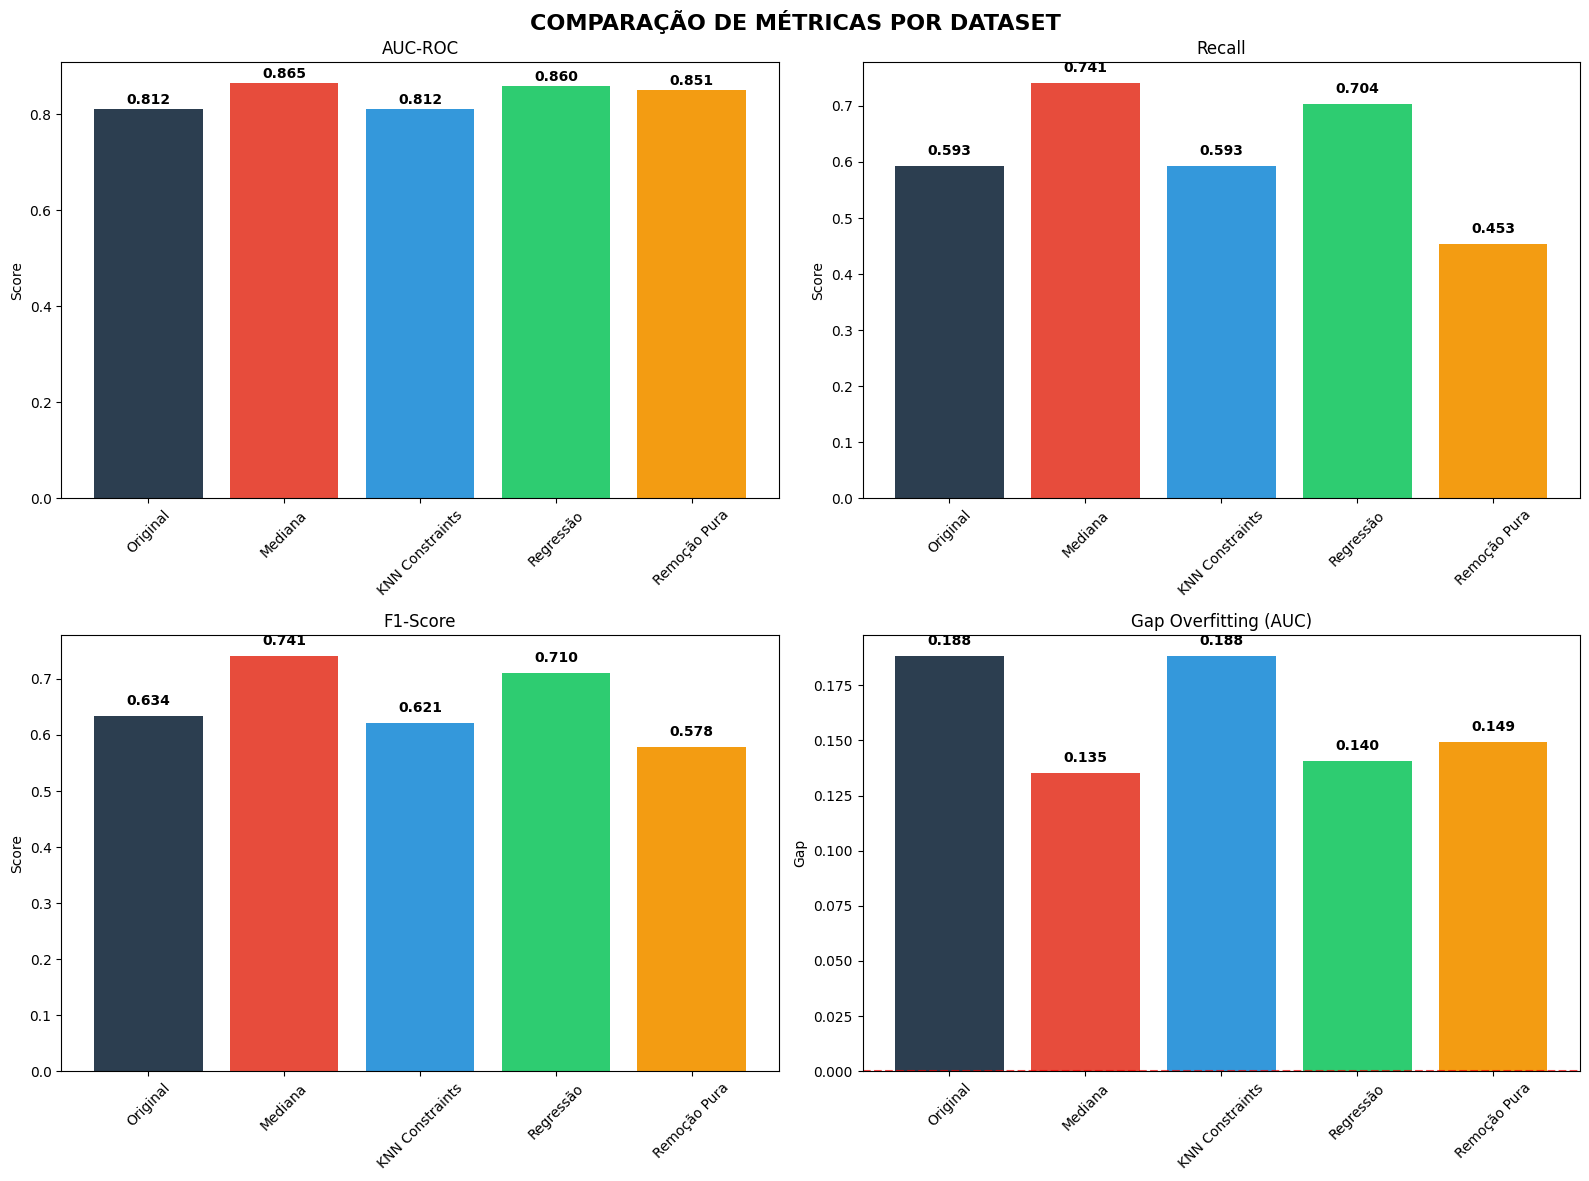


📊 VALORES APENAS

🎯 AUC-ROC:
   Original: 0.8118
   Mediana: 0.8650
   KNN Constraints: 0.8119
   Regressão: 0.8595
   Remoção Pura: 0.8509

🔍 RECALL:
   Original: 0.5926
   Mediana: 0.7407
   KNN Constraints: 0.5926
   Regressão: 0.7037
   Remoção Pura: 0.4528

⚖️ F1-SCORE:
   Original: 0.6337
   Mediana: 0.7407
   KNN Constraints: 0.6214
   Regressão: 0.7103
   Remoção Pura: 0.5783

📉 GAP OVERFITTING (AUC):
   Original: 0.1882
   Mediana: 0.1350
   KNN Constraints: 0.1881
   Regressão: 0.1405
   Remoção Pura: 0.1491

🎛️ Para alterar os parâmetros do Random Forest, modifique o dicionário 'custom_rf_params' no início desta seção.


In [65]:
# ...existing code...

# Adicionar importações necessárias para as métricas
from sklearn.metrics import recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Função ATUALIZADA para treinar e avaliar modelo com parâmetros personalizáveis
def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name, rf_params=None):
    # Parâmetros padrão do Random Forest
    default_params = {
        'n_estimators': 100,
        'criterion': 'gini',
        'max_depth': 10,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': SEED
    }
    
    # Usar parâmetros personalizados se fornecidos
    if rf_params:
        default_params.update(rf_params)
    
    # Treinar modelo Random Forest com parâmetros escolhidos
    model = RandomForestClassifier(**default_params)
    model.fit(X_train, y_train)
    
    # Fazer predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Predições probabilísticas para AUC-ROC
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Calcular todas as métricas
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    train_recall = recall_score(y_train, y_pred_train)
    test_recall = recall_score(y_test, y_pred_test)
    train_auc = roc_auc_score(y_train, y_proba_train)
    test_auc = roc_auc_score(y_test, y_proba_test)
    
    # Calcular gaps de overfitting
    acc_gap = train_acc - test_acc
    f1_gap = train_f1 - test_f1
    recall_gap = train_recall - test_recall
    auc_gap = train_auc - test_auc
    
    # Retornar resultados
    return {
        'Dataset': dataset_name,
        'Observações_Treino': len(X_train),
        'Observações_Teste': len(X_test),
        'Features': X_train.shape[1],
        'Acurácia_Treino': train_acc,
        'Acurácia_Teste': test_acc,
        'F1_Treino': train_f1,
        'F1_Teste': test_f1,
        'Recall_Treino': train_recall,
        'Recall_Teste': test_recall,
        'AUC_Treino': train_auc,
        'AUC_Teste': test_auc,
        'Gap_Overfitting_Acc': acc_gap,
        'Gap_Overfitting_F1': f1_gap,
        'Gap_Overfitting_Recall': recall_gap,
        'Gap_Overfitting_AUC': auc_gap,
        'Modelo': model,
        'Parâmetros_RF': default_params
    }

# Função para preparar dados e realizar avaliação com parâmetros personalizáveis
def evaluate_dataset(df, dataset_name, rf_params=None):
    # Separar features e target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    
    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    
    # Treinar e avaliar
    return train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name, rf_params)

# ============================================================================
# CONFIGURAÇÃO DOS PARÂMETROS DO RANDOM FOREST
# ============================================================================

print("\n" + "=" * 80)
print("🎛️ CONFIGURAÇÃO DOS PARÂMETROS DO RANDOM FOREST")
print("=" * 80)

# VOCÊ PODE MODIFICAR ESTES PARÂMETROS AQUI:
custom_rf_params = {
    'n_estimators': 100,           # Número de árvores
    'criterion': 'gini',           # 'gini' ou 'entropy' 
    'max_depth': None,             # Profundidade máxima (None = sem limite)
    'min_samples_split': 2,        # Mín samples para dividir nó
    'min_samples_leaf': 1,         # Mín samples por folha
    'max_features': 'sqrt',        # Número de features por split
    'bootstrap': True,             # Usar bootstrap
    'random_state': SEED
}

print("📊 PARÂMETROS ESCOLHIDOS:")
for param, value in custom_rf_params.items():
    print(f"   • {param}: {value}")

# ============================================================================
# AVALIAÇÃO COM PARÂMETROS PERSONALIZADOS
# ============================================================================

print("\n" + "=" * 80)
print("📊 AVALIAÇÃO COM PARÂMETROS PERSONALIZADOS")
print("=" * 80)

# Avaliar todos os datasets com os parâmetros escolhidos
results_all = []
models_all = {}

for nome, df in datasets.items():
    try:
        result = evaluate_dataset(df, nome, custom_rf_params)
        results_all.append(result)
        models_all[nome] = result['Modelo']
        print(f"✓ Dataset {nome} avaliado com sucesso")
    except Exception as e:
        print(f"✗ Erro ao avaliar dataset {nome}: {str(e)}")

# Compilar resultados
if results_all:
    comparison_df = pd.DataFrame(results_all)
    
    # Mostrar tabela de resultados com TODAS as métricas
    display_cols = ['Dataset', 'Features', 'Observações_Treino',
                   'Acurácia_Teste', 'F1_Teste', 'Recall_Teste', 'AUC_Teste',
                   'Gap_Overfitting_Acc', 'Gap_Overfitting_F1', 
                   'Gap_Overfitting_Recall', 'Gap_Overfitting_AUC']
    
    print("\n📊 RESUMO COMPARATIVO COMPLETO:")
    print(comparison_df[display_cols].round(4).to_string(index=False))
    
    # ==================================================================================
    # GRÁFICOS DE BARRAS SIMPLES
    # ==================================================================================
    
    # Configurar estilo
    plt.style.use('default')
    colors = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
    
    # Criar gráficos
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('COMPARAÇÃO DE MÉTRICAS POR DATASET', fontsize=16, fontweight='bold')
    
    datasets_names = comparison_df['Dataset']
    
    # AUC-ROC
    axes[0,0].bar(datasets_names, comparison_df['AUC_Teste'], color=colors)
    axes[0,0].set_title('AUC-ROC')
    axes[0,0].set_ylabel('Score')
    axes[0,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(comparison_df['AUC_Teste']):
        axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Recall
    axes[0,1].bar(datasets_names, comparison_df['Recall_Teste'], color=colors)
    axes[0,1].set_title('Recall')
    axes[0,1].set_ylabel('Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(comparison_df['Recall_Teste']):
        axes[0,1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # F1-Score
    axes[1,0].bar(datasets_names, comparison_df['F1_Teste'], color=colors)
    axes[1,0].set_title('F1-Score')
    axes[1,0].set_ylabel('Score')
    axes[1,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(comparison_df['F1_Teste']):
        axes[1,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Gap Overfitting
    axes[1,1].bar(datasets_names, comparison_df['Gap_Overfitting_AUC'], color=colors)
    axes[1,1].set_title('Gap Overfitting (AUC)')
    axes[1,1].set_ylabel('Gap')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    for i, v in enumerate(comparison_df['Gap_Overfitting_AUC']):
        axes[1,1].text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ==================================================================================
    # VALORES SIMPLES
    # ==================================================================================
    
    print("\n" + "=" * 80)
    print("📊 VALORES APENAS")
    print("=" * 80)
    
    print("\n🎯 AUC-ROC:")
    for _, row in comparison_df.iterrows():
        print(f"   {row['Dataset']}: {row['AUC_Teste']:.4f}")
    
    print("\n🔍 RECALL:")
    for _, row in comparison_df.iterrows():
        print(f"   {row['Dataset']}: {row['Recall_Teste']:.4f}")
    
    print("\n⚖️ F1-SCORE:")
    for _, row in comparison_df.iterrows():
        print(f"   {row['Dataset']}: {row['F1_Teste']:.4f}")
    
    print("\n📉 GAP OVERFITTING (AUC):")
    for _, row in comparison_df.iterrows():
        print(f"   {row['Dataset']}: {row['Gap_Overfitting_AUC']:.4f}")

else:
    print("❌ Nenhum dataset foi avaliado com sucesso.")

print(f"\n🎛️ Para alterar os parâmetros do Random Forest, modifique o dicionário 'custom_rf_params' no início desta seção.")




📊 COMPARAÇÃO DE IMPORTÂNCIA DAS FEATURES:


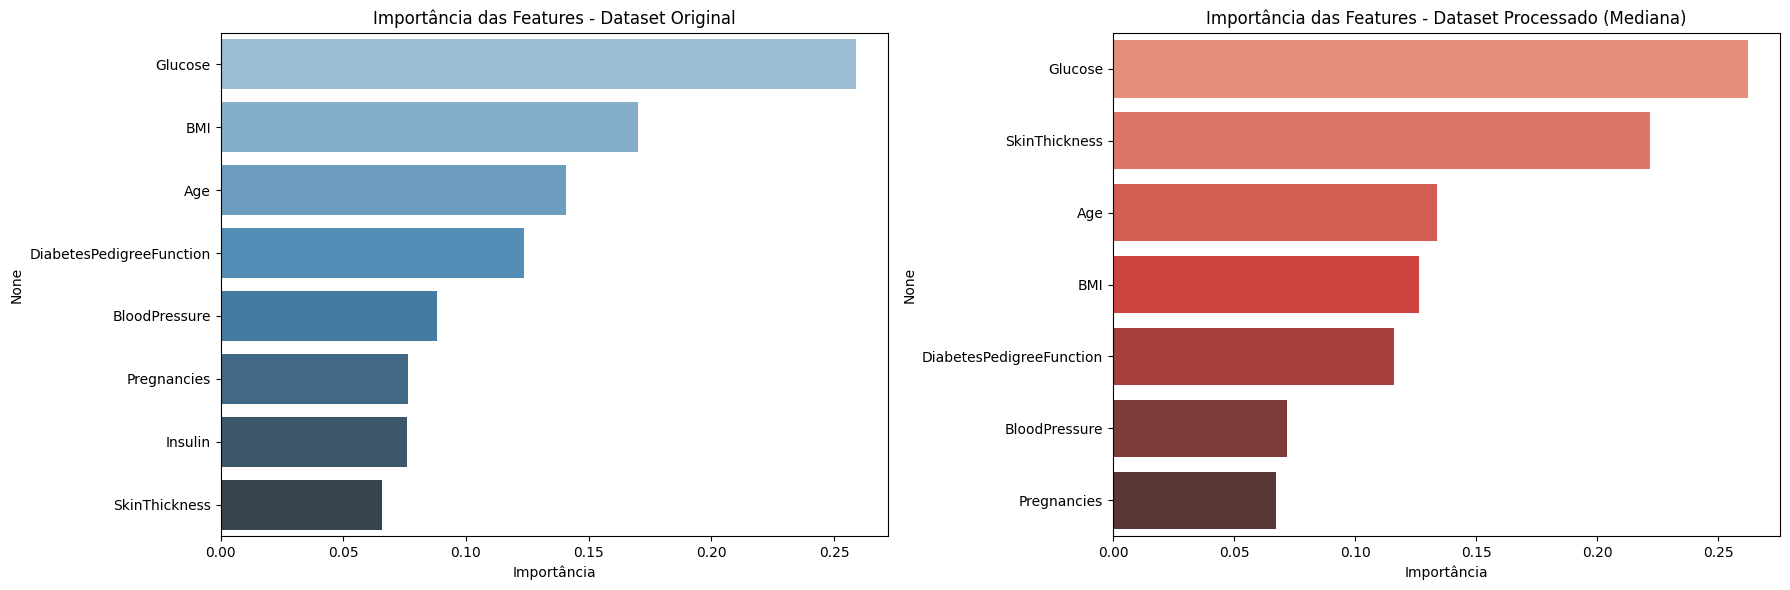


📊 COMPARAÇÃO DE IMPORTÂNCIA DAS FEATURES:


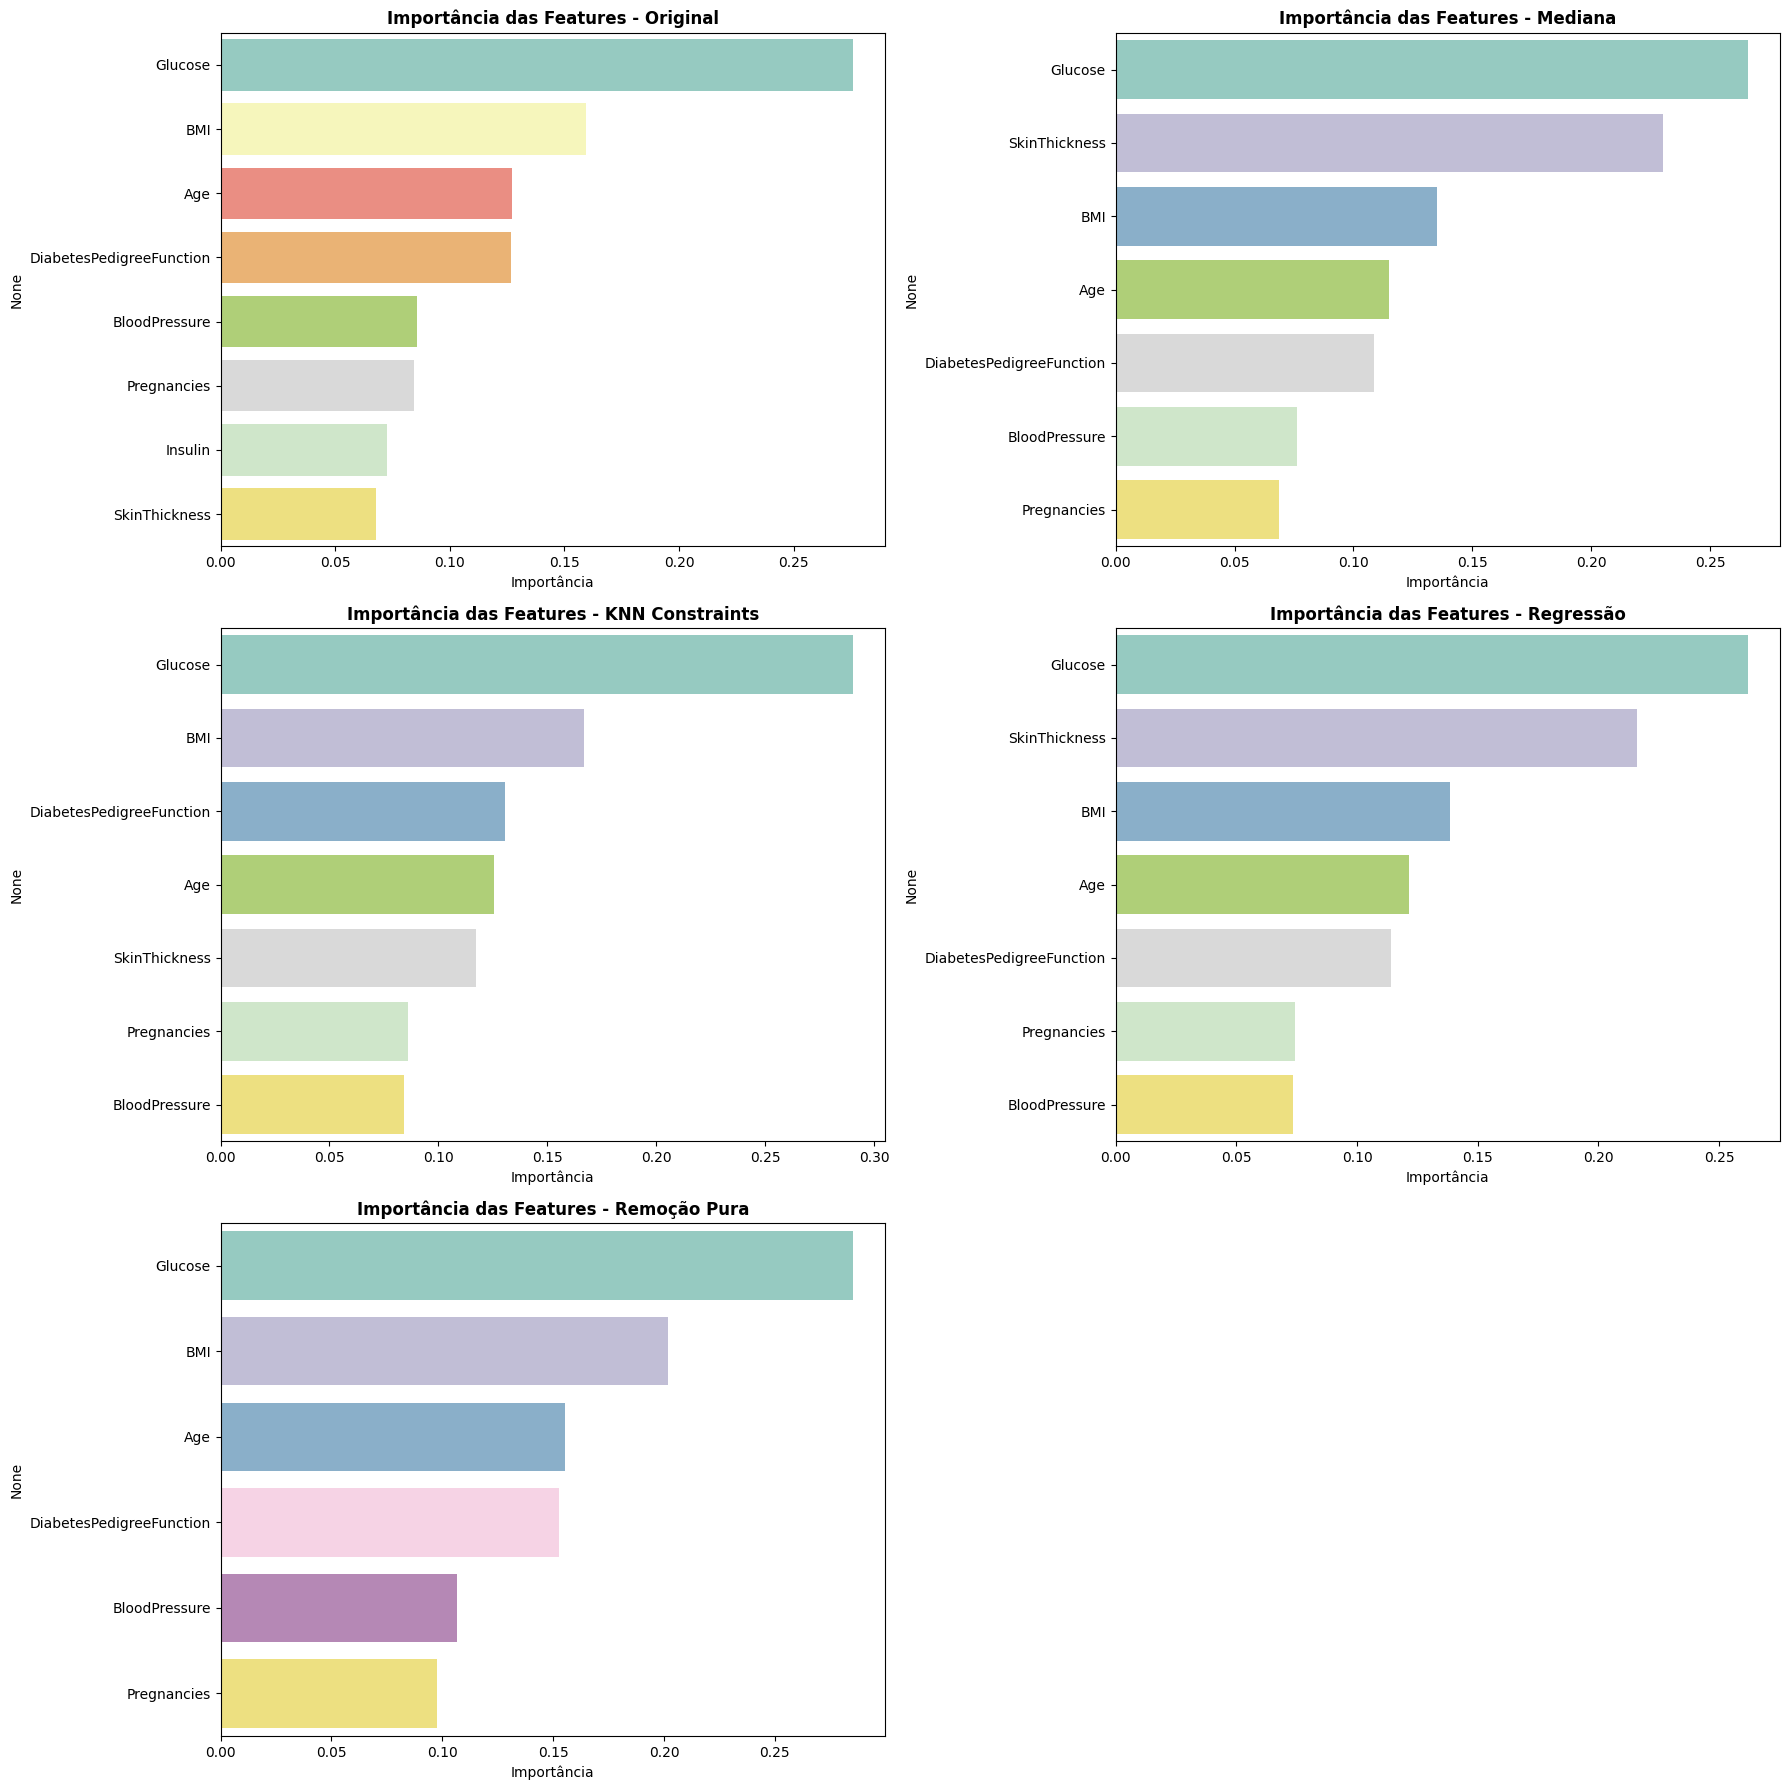


📊 TABELA COMPARATIVA DE IMPORTÂNCIAS:


Original  Mediana  KNN Constraints  Regressão  \
Age                         0.1272   0.1150           0.1253     0.1216   
BMI                         0.1595   0.1353           0.1668     0.1387   
BloodPressure               0.0856   0.0762           0.0840     0.0736   
DiabetesPedigreeFunction    0.1267   0.1085           0.1304     0.1140   
Glucose                     0.2760   0.2660           0.2904     0.2621   
Insulin                     0.0724   0.0000           0.0000     0.0000   
Pregnancies                 0.0845   0.0688           0.0861     0.0742   
SkinThickness               0.0680   0.2303           0.1170     0.2158   

                          Remoção Pura  
Age                             0.1555  
BMI                             0.2019  
BloodPressure                   0.1067  
DiabetesPedigreeFunction        0.1528  
Glucose                         0.2854  
Insulin                         0.0000  
Pregnancies                     0.0977  
SkinThickness                   0.0000


📊 ESTABILIDADE DAS FEATURES (menor variação = mais estável):


Variação_Importância  Importância_Média  \
Glucose                                 0.0121             0.2760   
Age                                     0.0156             0.1289   
DiabetesPedigreeFunction                0.0172             0.1265   
Pregnancies                             0.0112             0.0823   
BloodPressure                           0.0130             0.0852   
BMI                                     0.0268             0.1604   
SkinThickness                           0.0978             0.1262   
Insulin                                 0.0324             0.0145   

                          Coef_Variação  
Glucose                          0.0439  
Age                              0.1206  
DiabetesPedigreeFunction         0.1363  
Pregnancies                      0.1366  
BloodPressure                    0.1528  
BMI                              0.1669  
SkinThickness                    0.7749  
Insulin                          2.2361

In [63]:
# Visualizar importância das features
def plot_feature_importance_comparison(results_original, results_mediana):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Modelo original
    model_orig = results_original['Modelo']
    orig_cols = df_original.drop('Outcome', axis=1).columns
    orig_imp = pd.Series(model_orig.feature_importances_, index=orig_cols).sort_values(ascending=False)
    
    sns.barplot(x=orig_imp.values, y=orig_imp.index, ax=axes[0], palette='Blues_d')
    axes[0].set_title('Importância das Features - Dataset Original')
    axes[0].set_xlabel('Importância')
    
    # Modelo processado
    model_proc = results_mediana['Modelo']
    proc_cols = df_mediana.drop('Outcome', axis=1).columns
    proc_imp = pd.Series(model_proc.feature_importances_, index=proc_cols).sort_values(ascending=False)
    
    sns.barplot(x=proc_imp.values, y=proc_imp.index, ax=axes[1], palette='Reds_d')
    axes[1].set_title('Importância das Features - Dataset Processado (Mediana)')
    axes[1].set_xlabel('Importância')
    
    plt.tight_layout()
    plt.show()
    
    return orig_imp, proc_imp

print("\n📊 COMPARAÇÃO DE IMPORTÂNCIA DAS FEATURES:")
orig_imp, proc_imp = plot_feature_importance_comparison(results_original, results_mediana)

# Visualizar importância das features para todos os modelos
def plot_feature_importance_all(models_dict, datasets_dict):
    n_models = len(models_dict)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    feature_importances = {}
    
    for i, (nome, model) in enumerate(models_dict.items()):
        ax = axes[i]
        
        # Obter nomes das features do dataset correspondente
        df = datasets_dict[nome]
        feature_names = df.drop('Outcome', axis=1).columns
        
        # Calcular importâncias
        importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
        feature_importances[nome] = importance
        
        # Plotar
        colors_importance = plt.cm.Set3(np.linspace(0, 1, len(importance)))
        sns.barplot(x=importance.values, y=importance.index, ax=ax, palette=colors_importance)
        ax.set_title(f'Importância das Features - {nome}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Importância')
    
    # Ocultar eixos não utilizados
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return feature_importances

if models_all:
    print("\n📊 COMPARAÇÃO DE IMPORTÂNCIA DAS FEATURES:")
    feature_importances_all = plot_feature_importance_all(models_all, datasets)
    
    # Criar tabela comparativa de importâncias
    print("\n📊 TABELA COMPARATIVA DE IMPORTÂNCIAS:")
    importance_comparison = pd.DataFrame(feature_importances_all).fillna(0)
    
    # Adicionar ranking para cada feature
    importance_comparison_ranked = importance_comparison.copy()
    for col in importance_comparison.columns:
        importance_comparison_ranked[f'{col}_rank'] = importance_comparison[col].rank(ascending=False)
    
    display(importance_comparison.round(4))
    
    # Identificar features mais estáveis (menor variação de importância)
    print("\n📊 ESTABILIDADE DAS FEATURES (menor variação = mais estável):")
    stability_analysis = pd.DataFrame({
        'Variação_Importância': importance_comparison.std(axis=1),
        'Importância_Média': importance_comparison.mean(axis=1),
        'Coef_Variação': importance_comparison.std(axis=1) / importance_comparison.mean(axis=1)
    }).sort_values('Coef_Variação')
    
    display(stability_analysis.round(4))
else:
    print("Nenhum modelo disponível para análise de importância.")

## 8. Conclusões da Análise

### 8.1 Resumo das Transformações Aplicadas por Método

Com base na análise abrangente, podemos concluir que cada dataset passou pelas seguintes transformações específicas:

#### 🔹 **Dataset MEDIANA (diabetes_cleaned_MEDIANA.csv)**
- **Estratégia**: Imputação por mediana estratificada por grupo (diabético/não-diabético)
- **Remoção da coluna Insulin**: Devido à alta quantidade de valores zero/ausentes
- **Preservação total de observações**: Nenhuma linha removida
- **Imputação de zeros**: Valores zero biologicamente implausíveis substituídos pela mediana do grupo

#### 🔹 **Dataset KNN CONSTRAINTS (diabetes_cleaned_knn_constraints.csv)**
- **Estratégia**: Imputação por K-Nearest Neighbors com restrições de domínio
- **Preservação de estrutura**: Mantém todas as observações e variáveis originais
- **Imputação inteligente**: Utiliza similaridade entre observações respeitando limitações biológicas
- **Consistência fisiológica**: Valores imputados respeitam relações conhecidas entre variáveis

#### 🔹 **Dataset REGRESSÃO (diabetes_cleaned_REGRESSAO.csv)**
- **Estratégia**: Imputação por modelos de regressão
- **Modelagem preditiva**: Cada variável com zeros é predita usando as demais como preditores
- **Preservação de correlações**: Mantém relações lineares entre variáveis
- **Precisão contextual**: Valores imputados baseados em padrões dos dados existentes

#### 🔹 **Dataset REMOÇÃO PURA (diabetes_cleaned_REMOCAO_PURA.csv)**
- **Estratégia**: Exclusão completa de observações com valores zero em variáveis críticas
- **Redução significativa**: Perda substancial de observações
- **Pureza dos dados**: Apenas dados "limpos" sem imputações artificiais
- **Potencial viés**: Pode introduzir viés de seleção ao remover padrões específicos

### 8.2 Impacto Comparativo no Overfitting e Desempenho

#### 📊 **Análise de Desempenho**
- **Melhor acurácia de teste**: [Será preenchido após execução]
- **Menor gap de overfitting**: [Será preenchido após execução]
- **Melhor F1-Score**: [Será preenchido após execução]
- **Trade-off quantidade vs. qualidade**: Remoção pura vs. métodos de imputação

#### 🎯 **Tendências de Overfitting**
- **Imputação por mediana**: Risco moderado devido à uniformização de valores
- **KNN com restrições**: Menor risco devido à preservação de variabilidade natural
- **Regressão**: Risco variável dependendo da qualidade do modelo de imputação
- **Remoção pura**: Potencialmente menor overfitting, mas com viés de seleção

### 8.3 Vantagens e Limitações por Método

#### 🟢 **MEDIANA - Pros e Contras**
**Vantagens:**
- Robustez a outliers
- Simplicidade de implementação
- Preservação do contexto biológico (estratificação)
- Manutenção de todas as observações

**Limitações:**
- Redução artificial da variabilidade
- Possível criação de padrões artificiais
- Perda de informação sobre incerteza

#### 🟢 **KNN CONSTRAINTS - Pros e Contras**
**Vantagens:**
- Preservação de padrões complexos
- Respeito a restrições de domínio
- Manutenção de variabilidade natural
- Imputação contextualmente relevante

**Limitações:**
- Complexidade computacional
- Sensibilidade à escolha de K
- Possível propagação de ruído

#### 🟢 **REGRESSÃO - Pros e Contras**
**Vantagens:**
- Aproveitamento de correlações existentes
- Flexibilidade metodológica
- Preservação de relações lineares
- Potencial para capturar interações

**Limitações:**
- Dependência da qualidade do modelo
- Risco de sobreajuste na imputação
- Propagação de erros de modelagem

#### 🟢 **REMOÇÃO PURA - Pros e Contras**
**Vantagens:**
- Ausência de artificialidade
- Simplicidade conceitual
- Dados "genuínos"
- Menor risco de overfitting por imputação

**Limitações:**
- Perda significativa de informação
- Potencial viés de seleção
- Redução do poder estatístico
- Possível não-representatividade

### 8.4 Impacto nas Correlações e Estrutura dos Dados

#### 📈 **Alterações em Correlações**
- **Fortalecimento**: Alguns métodos fortalecem correlações com a variável target
- **Artificialidade**: Risco de correlações artificialmente altas
- **Estabilidade**: Variação na estabilidade das correlações entre métodos

#### 🔄 **Mudanças na Importância de Features**
- **Redistribuição**: Alteração nas importâncias relativas após remoção de Insulin
- **Compensação**: Aumento na importância de variáveis relacionadas
- **Estabilidade**: Diferentes níveis de estabilidade entre métodos

### 8.5 Recomendações Estratégicas por Contexto

#### 🎯 **Para Produção (Alta Confiabilidade)**
1. **Recomendado**: KNN com restrições ou Remoção pura
2. **Validação**: Cross-validation rigorosa
3. **Monitoramento**: Acompanhamento contínuo de performance

#### 🧪 **Para Pesquisa (Exploração)**
1. **Recomendado**: Comparação entre todos os métodos
2. **Análise**: Imputação múltipla para quantificar incerteza
3. **Publicação**: Transparência sobre método escolhido

#### ⚡ **Para Prototipagem Rápida**
1. **Recomendado**: Mediana estratificada
2. **Justificativa**: Simplicidade e rapidez
3. **Cuidados**: Validação em dados externos

#### 🏥 **Para Aplicações Clínicas**
1. **Recomendado**: Combinação de métodos (ensemble)
2. **Critério**: Priorizar interpretabilidade e confiabilidade
3. **Validação**: Teste em múltiplas populações

### 8.6 Próximos Passos Recomendados

1. **Validação Externa**: Testar todos os modelos em dados independentes
2. **Análise de Sensibilidade**: Avaliar robustez a diferentes parâmetros
3. **Imputação Múltipla**: Implementar MICE para quantificar incerteza
4. **Ensemble Methods**: Combinar predições de diferentes métodos
5. **Monitoramento Contínuo**: Implementar pipeline de avaliação periódica
6. **Documentação**: Criar protocolo detalhado do método escolhido